<a href="https://colab.research.google.com/github/sollama/socialprogress-happiness/blob/main/Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What are the factors affecting happiness?
In this notebook we are looking at how happiness correlates to social progress indexes. The data used was collected by the United Nations Sustainable Development Solutions Network in their annual *World Happiness Report*. This notebook contains data from 2015 to 2019.The social progress index data contains fifty-four indicators in the areas of basic human needs, foundations of well-being, and opportunity to progress show the relative performance of nations.


# Packages and Data

We begin our study by importing the packages and dependencies needed for this analysis as well as the data . 

In [ ]:
!pip install statsmodels --user --upgrade pip

     |████████████████████████████████| 9.5MB 5.7MB/s 
     |████████████████████████████████| 1.5MB 41.1MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
!pip install pingouin --user --upgrade pip

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 225 kB 4.1 MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.9-py3-none-any.whl size=223375 sha256=633d3aed8038e05a79a21881afb4219b9ad8100a6044255bc3b721bc988dbe12
  Stored in directory: /root/.cache/pip/wheels/27/3e/6c/9d6c06303c4cf51f96f0c6c7686cdd70e491065a4d820d4c87
  Created wheel for outdated: filename=outdated-0.2.0-py3-none-any.whl size=4961 sha256=642668bd0c4b288418fd0e7805114b37826625b24fc60cb9001e178809d7606b
  Stored in directory: /root/.cache/pip/wheels/0c/9b/ea/fb765f1c7a6bfcafcfa53aad43a060283901c383f41ba95891
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=0ba822f453959d10d1798cdee7094d6857bde110550b5008a3c0af76fd5cba0f
  Stored in directory: /root/.cache/pip/wheels/ce/74/d2/8ca76b7a1356197c45a88

In [ ]:
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cleaning Data

We begin by reading in our data files and removing some information that will not serve us throughout our study. We separate the data by years so we can properly label it in order to merge it later.

In [ ]:
df_spi = pd.read_excel('drive/MyDrive/DS4A/2011-2020-Social-Progress-Index.xlsx', sheet_name=1,skiprows=[0,1])

In [ ]:
df_WHR_2015 = pd.read_csv('drive/MyDrive/DS4A/World Happiness Report Data/2015.csv')
df_WHR_2016 = pd.read_csv('drive/MyDrive/DS4A/World Happiness Report Data/2016.csv')
df_WHR_2017 = pd.read_csv('drive/MyDrive/DS4A/World Happiness Report Data/2017.csv')
df_WHR_2018 = pd.read_csv('drive/MyDrive/DS4A/World Happiness Report Data/2018.csv')
df_WHR_2019 = pd.read_csv('drive/MyDrive/DS4A/World Happiness Report Data/2019.csv')

In [ ]:
del(df_WHR_2017['Whisker.high'], df_WHR_2017['Whisker.low'])
del(df_WHR_2016['Lower Confidence Interval'], df_WHR_2016['Upper Confidence Interval'])
del(df_WHR_2015['Standard Error'])

In [ ]:
#label WHR with year
df_WHR_2015['Year'] = 2015
df_WHR_2016['Year'] = 2016
df_WHR_2017['Year'] = 2017
df_WHR_2018['Year'] = 2018
df_WHR_2019['Year'] = 2019

We then clean the column names in order to match them between the different years as well as make them more readable. 

In [ ]:
#clean column names 
WHR_list = [df_WHR_2015, df_WHR_2016, df_WHR_2017, df_WHR_2018, df_WHR_2019]
column_names = {'Economy..GDP.per.Capita.':'Economy (GDP per Capita)', 'Overall rank':'Happiness Rank', 'Country or region':'Country','Happiness.Rank':'Happiness Rank', 'Happiness.Score':'Happiness Score', 
                'Health..Life.Expectancy.': 'Health (Life Expectancy)', 'Trust..Government.Corruption.': 'Trust (Government Corruption)','Perceptions of corruption':'Trust (Government Corruption)', 
                'Dystopia.Residual': 'Dystopia Residual', 'Freedom': 'Freedom to make life choices', 'Family':'Social support', 'Healthy life expectancy':'Health (Life Expectancy)', 'Score':'Happiness Score',
                'Economy':'Economy (GDP per Capita)', 'GDP per capita':'Economy (GDP per Capita)'}

df_WHR = pd.DataFrame()

for i in WHR_list:
  i = i.rename(columns=column_names)
  df_WHR = df_WHR.append(i)

#df_WHR

We then look at the basic description of the data we are working with to understand how to proceed.

In [ ]:
df_WHR.describe()

,Happiness Rank,Happiness Score,Economy (GDP per Capita),Social support,Health (Life Expectancy),Freedom to make life choices,Trust (Government Corruption),Generosity,Dystopia Residual,Year
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,781.000000,782.000000,470.000000,782.000000
mean,78.698210,5.379018,0.916047,1.078392,0.612416,0.411091,0.125436,0.218576,2.092717,2016.993606
std,45.182384,1.127456,0.407340,0.329548,0.248309,0.152880,0.105816,0.122321,0.565772,1.417364
min,1.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580,2015.000000
25%,40.000000,4.509750,0.606500,0.869363,0.440183,0.309768,0.054000,0.130000,1.737975,2016.000000
50%,79.000000,5.322000,0.982205,1.124735,0.647310,0.431000,0.091000,0.201982,2.094640,2017.000000
75%,118.000000,6.189500,1.236187,1.327250,0.808000,0.531000,0.156030,0.278832,2.455575,2018.000000
max,158.000000,7.769000,2.096000,1.644000,1.141000,0.724000,0.551910,0.838075,3.837720,2019.000000


We then look at the countries that are present in all 5 years so we know which data is missing and we can begin to clean up country names in the World Happiness Report data. 


In [ ]:
#find which countries to clean
df_countries = df_WHR.groupby(['Country'])['Year'].unique()
df_countries_count = df_WHR.groupby(['Country'])['Year'].count()
df_countries = df_countries_count.reset_index()
df_countries[df_countries['Year'] < 5]

,Country,Year
3,Angola,4
13,Belize,3
26,Central African Republic,4
31,Comoros,3
39,Djibouti,1
49,Gambia,1
58,Hong Kong,4
59,"Hong Kong S.A.R., China",1
78,Laos,4
81,Lesotho,4


In [ ]:
#making sure all WHR files match up
country_cleaning = {'Trinidad & Tobago':'Trinidad and Tobago','Taiwan Province of China':'Taiwan','Somaliland region':'Somaliland Region',
                    'North Cyprus':'Northern Cyprus','Hong Kong S.A.R., China':'Hong Kong','Macedonia':'Republic of Macedonia'}
#df_WHR.replace(country_cleaning)
df_WHR['Country'] = df_WHR['Country'].replace(country_cleaning)

We then make sure that country names are matching between the two datasets. 

In [ ]:
#matching WHR to SPI
country_cleanup_whr = {'Congo (Brazzaville)':'Congo, Republic of', 'Congo (Kinshasa)':'Congo, Democratic Republic of', 'Czech Republic':'Czechia','Ivory Coast':"Côte d'Ivoire",'Republic of Macedonia':'Republic of North Macedonia','South Korea': 'Korea, Republic of','Swaziland':'Eswatini'}
df_WHR['Country'] = df_WHR['Country'].replace(country_cleanup_whr)

country_cleanup_spi = {'Gambia':'Gambia, The',}
df_WHR['Country'] = df_WHR['Country'].replace(country_cleanup_spi)

In [ ]:
#lists countries alphabetically
countries_spi = pd.Series(df_spi['Country'].unique()).sort_values()
df_countries_spi = pd.DataFrame(df_spi['Country'].unique())
print(countries_spi)

1             Afghanistan
2                 Albania
3                 Algeria
175               Andorra
4                  Angola
              ...        
162               Vietnam
185    West Bank and Gaza
0                   World
163                Zambia
164              Zimbabwe
Length: 194, dtype: object


In [ ]:
countries_whr = pd.Series(df_WHR['Country'].unique()).sort_values()
countries_whr

152    Afghanistan
94         Albania
67         Algeria
136         Angola
29       Argentina
          ...     
22       Venezuela
74         Vietnam
135          Yemen
84          Zambia
114       Zimbabwe
Length: 165, dtype: object

After noticing some countries are not present in one dataset or the other we begin to deliberate on whether we should remove them from the data. Since the countries that are not present in the World Happiness Report do not give us any information that helps our analysis just from their Social Progress Index we decide to remove them. 

In [ ]:
countries_not_present_whr = [] #countries that exist in WHR but not in SPI
countries_present_whr = [] #countries present in both SPI and WHR
for country in countries_whr:
  if countries_spi.str.contains(country, regex = False).any():
    countries_present_whr.append(country)
  else:
    countries_not_present_whr.append(country)

countries_not_present_spi = []
countries_present_spi = []
for country in countries_spi:
  if countries_whr.str.contains(country, regex = False).any():
    countries_present_spi.append(country)
  else:
    countries_not_present_spi.append(country)

In [ ]:
#these will be deleted
countries_not_present_whr

['Hong Kong',
 'Libya',
 'Northern Cyprus',
 'Palestinian Territories',
 'Puerto Rico',
 'Somaliland Region',
 'Syria',
 'Venezuela',
 'Yemen']

In [ ]:
#Checked this list manually to the above to see if there are any alternate names
countries_not_present_spi

['Andorra',
 'Antigua and Barbuda',
 'Bahamas, The',
 'Barbados',
 'Brunei Darussalam',
 'Cabo Verde',
 'Cuba',
 'Equatorial Guinea',
 'Eritrea',
 'Fiji',
 'Grenada',
 'Guinea-Bissau',
 'Guyana',
 'Kiribati',
 'Korea, Democratic Republic of',
 'Liechtenstein',
 'Maldives',
 'Marshall Islands',
 'Micronesia',
 'Monaco',
 'Nauru',
 'Palau',
 'Papua New Guinea',
 'Samoa',
 'San Marino',
 'Sao Tome and Principe',
 'Seychelles',
 'Solomon Islands',
 'St. Kitts and Nevis',
 'St. Lucia',
 'St. Vincent and the Grenadines',
 'Timor-Leste',
 'Tonga',
 'Tuvalu',
 'Vanuatu',
 'Vatican City',
 'West Bank and Gaza',
 'World']

Now that we have our countries cleaned up it should be easier to join our two datasets and begin working on them. Because we want to match country name and year we create a column containing these two data points in order to match them based on it. We then do a left join on the social progress dataset so that we can keep the data where happiness was not reported and social progress was in case we need that later.

In [ ]:
#Created a new key column to join with
df_WHR['Index_country_year'] = df_WHR['Country'] + ' '+ df_WHR['Year'].astype(str)

In [ ]:
#Created a primary key column to match onto
df_spi['Index_country_year'] = df_spi['Country']+' '+df_spi['SPI year'].astype(str)

In [ ]:
#Left joined SPI (left) with WHR (right). This keeps the years where happiness isnt reported in the Dataframe
df_master =pd.merge(df_spi, df_WHR,how = 'left', on = 'Index_country_year')

Now we want to be able to split our data by continent. So we add a column containing the continent name by creating variables that contain the list of countries in each continent and then matching the country name to the list. 

In [ ]:
continents = {'World':'World',
       'South America': ['Argentina', 'Colombia','Chile','Bolivia', 'Brazil','Ecuador','Guyana','Paraguay', 'Peru','Suriname','Uruguay',],
       'North America':['St. Kitts and Nevis', 'Dominica','St. Vincent and the Grenadines','St. Lucia','Grenada','Bahamas, The', 'Antigua and Barbuda', 'Belize','United States','Nicaragua','Barbados', 'Canada', 'Costa Rica','Cuba','Dominican Republic','El Salvador', 'Guatemala','Haiti','Honduras', 'Jamaica','Mexico','Panama','Trinidad and Tobago'],
       'Europe':['Kosovo','San Marino','Monaco','Liechtenstein','Andorra','Republic of North Macedonia','Hungary','Albania','Armenia','Austria', 'Azerbaijan','Belarus', 'Belgium','Bosnia and Herzegovina','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Iceland','Ireland','Italy','Latvia','Lithuania', 'Luxembourg', 'Georgia','Malta', 'Moldova','Montenegro','Netherlands','Norway', 'Poland', 'Portugal','Romania','Serbia', 'Slovakia', 'Slovenia','Spain','Sweden', 'Switzerland','Ukraine','United Kingdom','Vatican City'],
      'Oceania':['Vanuatu','Solomon Islands','Australia','Fiji','Micronesia','Marshall Islands','Nauru','Palau','Kiribati','New Zealand','Papua New Guinea','Samoa','Tonga','Tuvalu'],
      'Asia':['West Bank and Gaza','Taiwan','Brunei Darussalam','Timor-Leste','Myanmar', 'Afghanistan','Bahrain','Bangladesh','Bhutan','Cambodia','China','India','Indonesia','Iran','Iraq','Israel','Japan', 'Jordan', 'Kazakhstan','Korea, Democratic Republic of', 'Korea, Republic of','Kuwait','Kyrgyzstan','Laos',  'Lebanon','Malaysia','Maldives','Mongolia','Nepal','Oman', 'Pakistan','Philippines','Qatar', 'Russia','Saudi Arabia','Singapore','Sri Lanka','Tajikistan','Thailand','Turkey','Turkmenistan','United Arab Emirates','Uzbekistan', 'Vietnam'],
      'Africa':['Eswatini','Comoros','Algeria', 'Angola','Benin','Botswana','Burkina Faso','Burundi','Chad','Cabo Verde','Cameroon', 'Central African Republic', 'Congo, Democratic Republic of', 'Congo, Republic of','Djibouti','Egypt',  'Equatorial Guinea', 'Eritrea','Ethiopia', 'Gabon','Gambia, The','Ghana','Guinea', 'Guinea-Bissau', "Côte d'Ivoire",'Kenya', 'Lesotho', 'Liberia','Madagascar', 'Malawi', 'Mali','Mauritania','Mauritius', 'Morocco','Mozambique','Namibia', 'Niger', 'Nigeria','Rwanda','Sao Tome and Principe','Senegal','Sierra Leone','Somalia','South Africa', 'South Sudan','Sudan',  'Tanzania','Togo','Tunisia','Seychelles','Uganda', 'Zambia','Zimbabwe']}

In [ ]:
south_america = ['Argentina', 'Colombia','Chile','Bolivia', 'Brazil','Ecuador','Guyana','Paraguay', 'Peru','Suriname','Uruguay',]
north_america = ['St. Kitts and Nevis', 'Dominica','St. Vincent and the Grenadines','St. Lucia','Grenada','Bahamas, The', 'Antigua and Barbuda', 'Belize','United States','Nicaragua','Barbados', 'Canada', 'Costa Rica','Cuba','Dominican Republic','El Salvador', 'Guatemala','Haiti','Honduras', 'Jamaica','Mexico','Panama','Trinidad and Tobago']
europe = ['Kosovo','San Marino','Monaco','Liechtenstein','Andorra','Republic of North Macedonia','Hungary','Albania','Armenia','Austria', 'Azerbaijan','Belarus', 'Belgium','Bosnia and Herzegovina','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Iceland','Ireland','Italy','Latvia','Lithuania', 'Luxembourg', 'Georgia','Malta', 'Moldova','Montenegro','Netherlands','Norway', 'Poland', 'Portugal','Romania','Serbia', 'Slovakia', 'Slovenia','Spain','Sweden', 'Switzerland','Ukraine','United Kingdom','Vatican City']
oceania = ['Vanuatu','Solomon Islands','Australia','Fiji','Micronesia','Marshall Islands','Nauru','Palau','Kiribati','New Zealand','Papua New Guinea','Samoa','Tonga','Tuvalu']
asia = ['West Bank and Gaza','Taiwan','Brunei Darussalam','Timor-Leste','Myanmar', 'Afghanistan','Bahrain','Bangladesh','Bhutan','Cambodia','China','India','Indonesia','Iran','Iraq','Israel','Japan', 'Jordan', 'Kazakhstan','Korea, Democratic Republic of', 'Korea, Republic of','Kuwait','Kyrgyzstan','Laos',  'Lebanon','Malaysia','Maldives','Mongolia','Nepal','Oman', 'Pakistan','Philippines','Qatar', 'Russia','Saudi Arabia','Singapore','Sri Lanka','Tajikistan','Thailand','Turkey','Turkmenistan','United Arab Emirates','Uzbekistan', 'Vietnam']
africa = ['Eswatini','Comoros','Algeria', 'Angola','Benin','Botswana','Burkina Faso','Burundi','Chad','Cabo Verde','Cameroon', 'Central African Republic', 'Congo, Democratic Republic of', 'Congo, Republic of','Djibouti','Egypt',  'Equatorial Guinea', 'Eritrea','Ethiopia', 'Gabon','Gambia, The','Ghana','Guinea', 'Guinea-Bissau', "Côte d'Ivoire",'Kenya', 'Lesotho', 'Liberia','Madagascar', 'Malawi', 'Mali','Mauritania','Mauritius', 'Morocco','Mozambique','Namibia', 'Niger', 'Nigeria','Rwanda','Sao Tome and Principe','Senegal','Sierra Leone','Somalia','South Africa', 'South Sudan','Sudan',  'Tanzania','Togo','Tunisia','Seychelles','Uganda', 'Zambia','Zimbabwe']

In [ ]:
south_america = pd.Series(south_america)
north_america = pd.Series(north_america)
europe = pd.Series(europe)
oceania = pd.Series(oceania)
asia = pd.Series(asia)
africa = pd.Series(africa)

In [ ]:
for i, country in df_master['Country_x'].iteritems():
  if south_america.str.contains(country, regex = False).any():
    df_master.loc[i,'Continent'] = 'South America'
  elif north_america.str.contains(country, regex = False).any():
    df_master.loc[i,'Continent'] = 'North America'
  elif europe.str.contains(country, regex = False).any():
    df_master.loc[i,'Continent'] = 'Europe'
  elif oceania.str.contains(country, regex = False).any():
    df_master.loc[i,'Continent'] = 'Oceania'
  elif asia.str.contains(country, regex = False).any():
    df_master.loc[i,'Continent'] = 'Asia'
  elif africa.str.contains(country, regex = False).any():
    df_master.loc[i,'Continent'] ='Africa'
  else:
    df_master.loc[i,'Continent'] = 'World'


In [ ]:
#Date was originally SPI Year, I modified to Happiness since we arent using the other years anyway
df_master["Year_DT"] = pd.to_datetime(df_master['Year'], format='%Y')

In [ ]:
#Dropping the Unused years
df_master.dropna(subset = ['Year_DT'], inplace=True)

We can now save our combined dataset into a CSV file. 

In [ ]:
with open('drive/My Drive/DS4A/Cleaned-Datasets/master.csv', 'w') as f:
  df_master.to_csv(f)

# Exploring Data

In [ ]:
df_master = pd.read_csv('drive/MyDrive/DS4A/Cleaned-Datasets/master.csv')

After pulling in our master dataframe we can start looking at the relationship between Happiness Score and Social Progress Index. To make this more insightful we split the data by continent to see if the trendlines are different in each region of the world. We then find the outliers to see if there's anything interesting there. 

In [ ]:
# Pull dataframe of countries by continent based on mean values
mean_by_country = df_master.groupby(['Continent','Country_x']).mean().reset_index()
mean_country_dropna = mean_by_country[['Happiness Score','Social Progress Index']].dropna()

# Find slope and intercept of linear regression
slope, intercept, r_value, _, _ = stats.linregress(mean_country_dropna['Happiness Score'],mean_country_dropna['Social Progress Index'])

In [ ]:
# Find outliers that fall outside linear regression line by one standard error
std_dev = 15
mean_by_country['Outlier'] = (mean_by_country['Social Progress Index'] > (mean_by_country['Happiness Score']*slope + intercept + 2 * std_dev)) | (mean_by_country['Social Progress Index'] < (mean_by_country['Happiness Score']*slope + intercept - 2 * std_dev))

# Pull outlier dataframe
#df_outliers = mean_by_country[outliers]
#df_outliers

From the following plot we can see that the trendline is quite similar for all continents except for Europe. In general as social progress increases, so does happiness. But in Europe, a continent with high social progress index, it does not seem to have the same effect in happiness for all countries. There appears to be a group of countries found in the upper left region of the plot for whom their social progress does not increase their happiness level to the global expected score. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


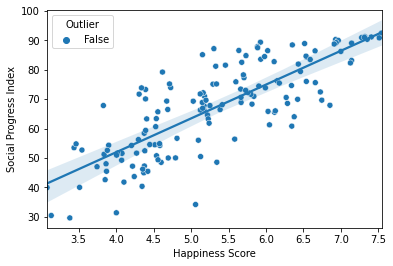

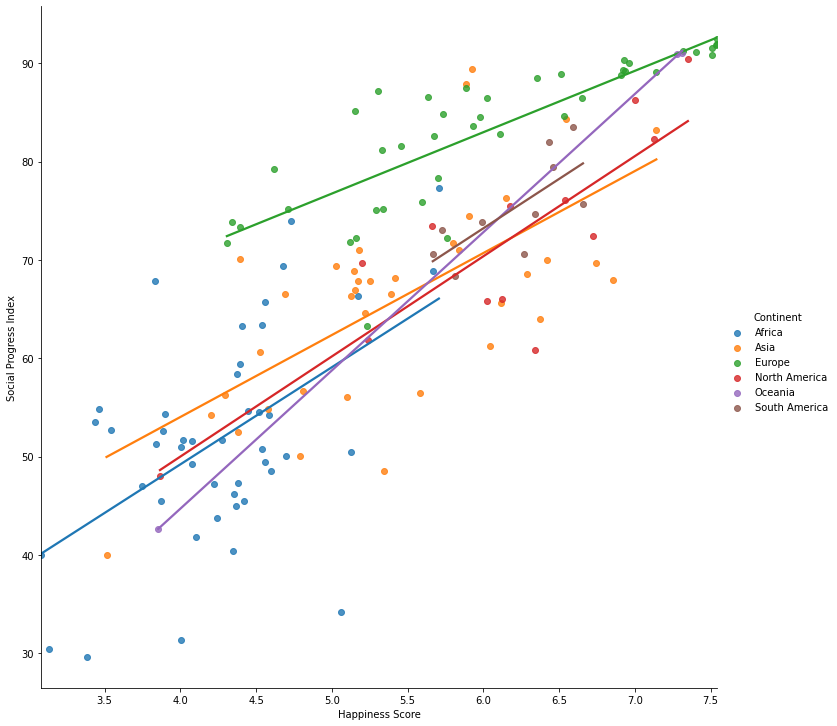

In [ ]:
# Plot all countries 
ax = sns.scatterplot('Happiness Score','Social Progress Index', data=mean_by_country, hue='Outlier') 
sns.regplot('Happiness Score','Social Progress Index', data=mean_by_country, scatter=False, ci=100, ax=ax)
sns.lmplot('Happiness Score','Social Progress Index', data=mean_by_country, height=10, ci=None, hue='Continent')

We can see a very similar trend for the ranks, which is to be expected as the ranks are derived from their scores. 

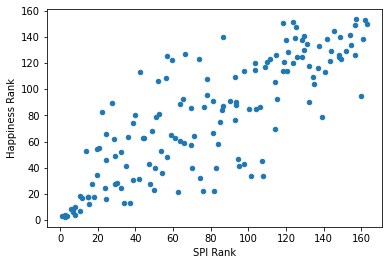

In [ ]:
#Scatterplot of Average Happiness Rank vs SPI Rank
sctr = df_master.groupby(['Country_x']).mean()
sctr.plot.scatter('SPI Rank','Happiness Rank')

We then generate the same scatterplot for each year to make sure everything looks normal. 

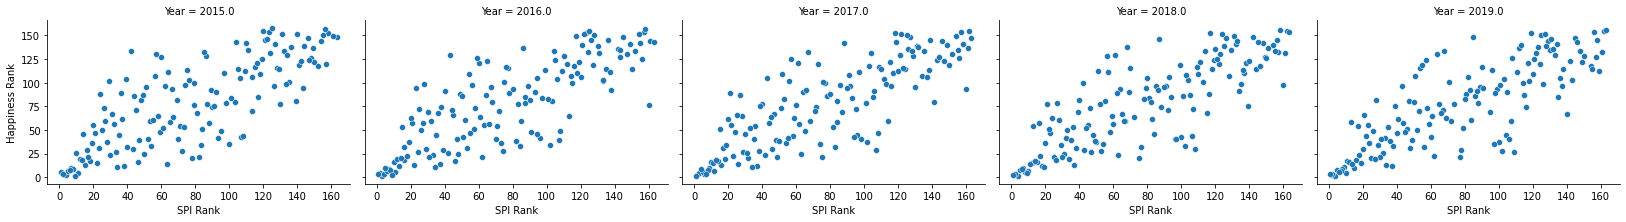

In [ ]:
#Scatterplots of each country's respective ranks seperated by years where happiness is reported
sctr_years = df_master.groupby(['Year', 'Country_x']).mean().reset_index()
pm = sns.FacetGrid(sctr_years, col='Year', aspect=1.5)
pm.map_dataframe(sns.scatterplot,x='SPI Rank',y='Happiness Rank')
pm.set_axis_labels("SPI Rank",'Happiness Rank')

We generated an adjusted happiness score to make sure that these were on a similar scale that would make our visualizations clearer for our audience. 

In [ ]:
df_master['Adjusted Happiness Score'] = df_master['Happiness Score']*10

Then we make sure that these relationships are statistically signicant by performing a t-test. Based on the p-value we determined that they are. 

In [ ]:
#P value
stats.ttest_ind(df_master['Social Progress Index'],df_master['Adjusted Happiness Score'], nan_policy = 'omit',equal_var = False)


Ttest_indResult(statistic=20.185426213460666, pvalue=3.4621724222125704e-79)

Next we look at the correlation between social progress indicators and happiness indicators by generating a correlation table. 

In [ ]:
corr_table = df_master.copy()
corr_table = corr_table.drop(['SPI Rank', 'Country_x','Year', 'SPI country code', 'SPI year', 'Status','Index_country_year', 'Country_y', 'Region', 'Happiness Rank'], axis=1)

In [ ]:
corrmat = corr_table.corr() 

In [ ]:
corr_pairs = corrmat.unstack()
print(corr_pairs)
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
print(sorted_pairs)
negative_pairs = sorted_pairs[sorted_pairs < 0]
print(negative_pairs)
strong_pairs = sorted_pairs[(abs(sorted_pairs) > 0.5) & (abs(sorted_pairs) != 1)]
print(strong_pairs)

Unnamed: 0                Unnamed: 0                       1.000000
                          Social Progress Index            0.004911
                          Basic Human Needs                0.016063
                          Foundations of Wellbeing         0.018019
                          Opportunity                     -0.020681
                                                             ...   
Adjusted Happiness Score  Freedom to make life choices     0.537256
                          Trust (Government Corruption)    0.414837
                          Generosity                       0.157370
                          Dystopia Residual                0.482287
                          Adjusted Happiness Score         1.000000
Length: 5776, dtype: float64
Populations using unsafe or unimproved water sources (%)  Water and Sanitation                                       -0.960320
Water and Sanitation                                      Populations using unsafe or unimproved

In [ ]:
strong_pairs = corr_pairs[(abs(corr_pairs) > 0.5) & (abs(corr_pairs) != 1)].sort_values(kind="quicksort")
print(strong_pairs)

Populations using unsafe or unimproved water sources (%)  Water and Sanitation                                       -0.960320
Water and Sanitation                                      Populations using unsafe or unimproved water sources (%)   -0.960320
Populations using unsafe or unimproved water sources (%)  Basic Human Needs                                          -0.957499
Basic Human Needs                                         Populations using unsafe or unimproved water sources (%)   -0.957499
Water and Sanitation                                      Populations using unsafe or unimproved sanitation (%)      -0.951782
                                                                                                                        ...   
Basic Human Needs                                         Nutrition and Basic Medical Care                            0.977776
Water and Sanitation                                      Basic Human Needs                                    

In [ ]:
happiness_metrics = ['Happiness Rank', 'Happiness Score',
       'Economy (GDP per Capita)', 'Social support',
       'Health (Life Expectancy)', 'Freedom to make life choices',
       'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual']
spi_metrics = ['Social Progress Index', 'Basic Human Needs',
       'Foundations of Wellbeing', 'Opportunity',
       'Nutrition and Basic Medical Care', 'Water and Sanitation', 'Shelter',
       'Personal Safety', 'Access to Basic Knowledge',
       'Access to Information and Communications', 'Health and Wellness',
       'Environmental Quality', 'Personal Rights',
       'Personal Freedom and Choice', 'Inclusiveness',
       'Access to Advanced Education', 'Undernourishment (% of pop.)',
       'Deaths from infectious diseases (deaths/100,000)',
       'Child stunting (% of children)',
       'Maternal mortality rate (deaths/100,000 live births)',
       'Child mortality rate (deaths/1,000 live births)',
       'Unsafe water, sanitation and hygiene attributable deaths (per 100,000 pop.)',
       'Populations using unsafe or unimproved water sources (%)',
       'Populations using unsafe or unimproved sanitation (%)',
       'Usage of clean fuels and technology for cooking (% of pop.)',
       'Access to electricity (% of pop.)',
       'Household air pollution attributable deaths (deaths/100,000)',
       'Traffic deaths (deaths/100,000)',
       'Political killings and torture (0=low freedom; 1=high freedom)',
       'Perceived criminality (1=low; 5=high)',
       'Homicide rate (deaths/100,000)',
       'Access to quality education (0=unequal; 4=equal)',
       'Women with no schooling',
       'Gender parity in secondary attainment (distance from parity)',
       'Primary school enrollment (% of children)',
       'Secondary school attainment (% of population)',
       'Access to online governance (0=low; 1=high)',
       'Media censorship (0=frequent; 4=rare)', 'Internet users (% of pop.)',
       'Mobile telephone subscriptions (subscriptions/100 people)',
       'Access to quality healthcare (0=unequal; 4=equal)',
       'Access to essential services  (0=none; 100=full coverage)',
       'Premature deaths from non-communicable diseases (deaths/100,000)',
       'Life expectancy at 60 (years)',
       'Greenhouse gas emissions (total CO2 equivalents)',
       'Particulate matter ', 'Biome protection',
       'Outdoor air pollution attributable deaths (deaths/100,000)',
       'Political rights (0=no rights; 40=full rights)',
       'Freedom of expression (0=no freedom; 1=full freedom)',
       'Freedom of religion (0=no freedom; 4=full freedom)',
       'Access to justice (0=non-existent; 1=observed)',
       'Property rights for women (0=no right; 5=full rights)',
       'Vulnerable employment (% of employees)',
       'Corruption (0=high; 100=low)', 'Early marriage (% of women)',
       'Satisfied demand for contraception (% of women)',
       'Equality of political power by socioeconomic position (0=unequal power; 4=equal power)',
       'Equality of political power by social group (0=unequal power; 4=equal power)',
       'Equality of political power by gender (0=unequal power; 4=equal power)',
       'Discrimination and violence against minorities (0=low; 10=high)',
       'Acceptance of gays and lesbians (0=low; 100=high)',
       'Quality weighted universities (points)', 'Citable documents',
       'Women with advanced education (%)', 'Years of tertiary schooling']
spi_metrics2 = ['Social Progress Index', 'Basic Human Needs',
       'Foundations of Wellbeing', 'Opportunity',
       'Nutrition and Basic Medical Care', 'Water and Sanitation', 'Shelter',
       'Personal Safety', 'Access to Basic Knowledge',
       'Access to Information and Communications', 'Health and Wellness',
       'Environmental Quality', 'Personal Rights',
       'Personal Freedom and Choice', 'Inclusiveness',
       'Access to Advanced Education']
spi_metrics3 = ['Undernourishment (% of pop.)',
       'Deaths from infectious diseases (deaths/100,000)',
       'Child stunting (% of children)',
       'Maternal mortality rate (deaths/100,000 live births)',
       'Child mortality rate (deaths/1,000 live births)',
       'Unsafe water, sanitation and hygiene attributable deaths (per 100,000 pop.)',
       'Populations using unsafe or unimproved water sources (%)',
       'Populations using unsafe or unimproved sanitation (%)',
       'Usage of clean fuels and technology for cooking (% of pop.)',
       'Access to electricity (% of pop.)',
       'Household air pollution attributable deaths (deaths/100,000)',
       'Traffic deaths (deaths/100,000)',
       'Political killings and torture (0=low freedom; 1=high freedom)',
       'Perceived criminality (1=low; 5=high)',
       'Homicide rate (deaths/100,000)',
       'Access to quality education (0=unequal; 4=equal)',
       'Women with no schooling',
       'Gender parity in secondary attainment (distance from parity)',
       'Primary school enrollment (% of children)',
       'Secondary school attainment (% of population)',
       'Access to online governance (0=low; 1=high)',
       'Media censorship (0=frequent; 4=rare)', 'Internet users (% of pop.)',
       'Mobile telephone subscriptions (subscriptions/100 people)',
       'Access to quality healthcare (0=unequal; 4=equal)',
       'Access to essential services  (0=none; 100=full coverage)',
       'Premature deaths from non-communicable diseases (deaths/100,000)',
       'Life expectancy at 60 (years)',
       'Greenhouse gas emissions (total CO2 equivalents)',
       'Particulate matter ', 'Biome protection',
       'Outdoor air pollution attributable deaths (deaths/100,000)',
       'Political rights (0=no rights; 40=full rights)',
       'Freedom of expression (0=no freedom; 1=full freedom)',
       'Freedom of religion (0=no freedom; 4=full freedom)',
       'Access to justice (0=non-existent; 1=observed)',
       'Property rights for women (0=no right; 5=full rights)',
       'Vulnerable employment (% of employees)',
       'Corruption (0=high; 100=low)', 'Early marriage (% of women)',
       'Satisfied demand for contraception (% of women)',
       'Equality of political power by socioeconomic position (0=unequal power; 4=equal power)',
       'Equality of political power by social group (0=unequal power; 4=equal power)',
       'Equality of political power by gender (0=unequal power; 4=equal power)',
       'Discrimination and violence against minorities (0=low; 10=high)',
       'Acceptance of gays and lesbians (0=low; 100=high)',
       'Quality weighted universities (points)', 'Citable documents',
       'Women with advanced education (%)', 'Years of tertiary schooling']
corrmat_dedup = df_master[df_master.columns[1:]].corr()[happiness_metrics]

In [ ]:
corrmat_dedup_dropindex = corrmat_dedup.drop(labels=None, axis=0, index=happiness_metrics, columns=None, level=None, inplace=False, errors='raise')
corrmat_dedup_new = corrmat_dedup.loc[corrmat_dedup.index.isin(spi_metrics2)]
corrmat_dedup_micro = corrmat_dedup.loc[corrmat_dedup.index.isin(spi_metrics3)]


We also created a correlation matrix comparing the main happiness and social progress indicators. We can see that the GDP and Life expectancy are strongly correlated to many of the social progress indicator categories.

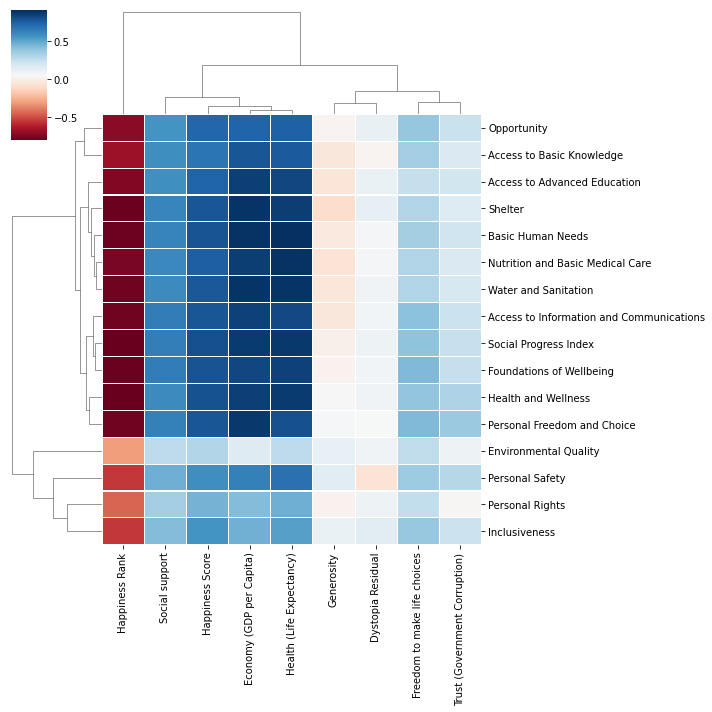

In [ ]:
cg = sns.clustermap(corrmat_dedup_new, cmap ="RdBu", linewidths = 0.1); 
#plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
  

cg

We also did a correlation matrix comparing happiness indicators to the social progress indicators in more detail.

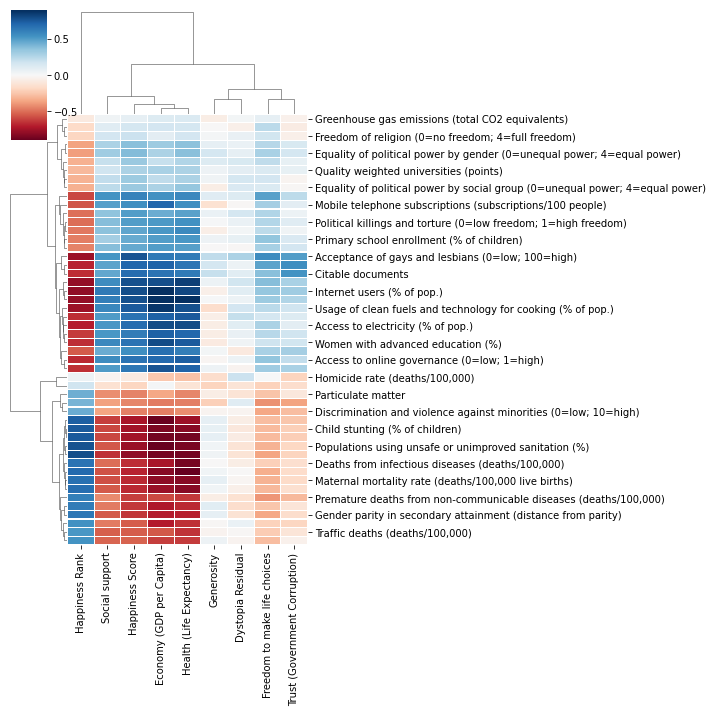

In [ ]:
cg3 = sns.clustermap(corrmat_dedup_micro, cmap ="RdBu", linewidths = 0.1); 
#plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
cg3

We generate a bar plot of both scores for each continent. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


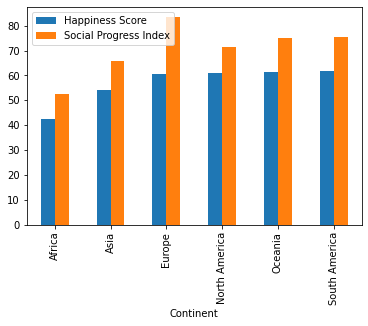

In [ ]:
df_by_continent = df_master.groupby(['Continent'])['Happiness Score','Social Progress Index'].mean().reset_index()
df_by_continent['Happiness Score'] = df_by_continent['Happiness Score'] *10
df_by_continent.plot.bar(x='Continent',y=['Happiness Score','Social Progress Index'],legend=True)

We also generated a combined score which is the average of the adjusted happiness score and the social progress index. 

In [ ]:
df_master['Combined Score'] = (df_master['Adjusted Happiness Score'] + df_master['Social Progress Index'])/2

# Eastern vs Western Europe 


Due to the observed differences in happiness in Eastern vs Western Europe we'd like to take a closer look at the differences in SPI metrics between the two regions. 

We first split Europe into a separate dataframe and add an 'Eastern vs Western' column. 

In [ ]:
eastern_europe = ['Albania', 'Armenia','Azerbaijan', 'Belarus','Bosnia and Herzegovina', 'Bulgaria','Croatia','Cyprus','Czechia','Georgia','Greece','Hungary','Latvia','Lithuania','Moldova','Montenegro','Poland','Republic of North Macedonia','Romania','Serbia','Slovakia','Slovenia','Ukraine']
western_europe = ['Austria','Belgium','Denmark','France','Germany','Ireland','Italy','Netherlands','Portugal','Spain','Switzerland','United Kingdom']
eastern = pd.Series(eastern_europe)
western = pd.Series(western_europe)

In [ ]:
df_europe = df_master.loc[df_master['Continent']=='Europe'].copy()

In [ ]:
for i, country in df_europe['Country_y'].iteritems():
  if eastern.str.contains(country, regex = False).any():
    df_europe.loc[i,'Eastern or Western'] = 'Eastern Europe'
  elif western.str.contains(country, regex = False).any():
    df_europe.loc[i,'Eastern or Western'] = 'Western Europe'


We then loop through the SPI metrics so we can generate a boxplot comparing the values of Eastern and Western Europe. 

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and ma

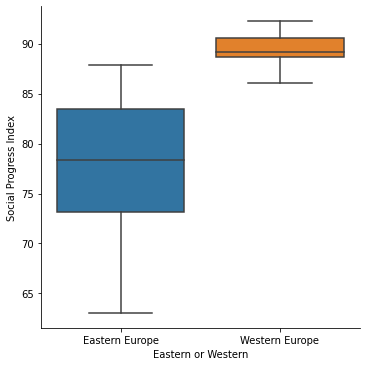

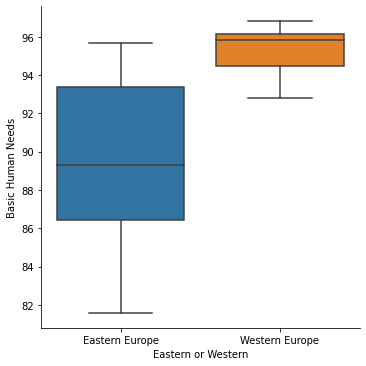

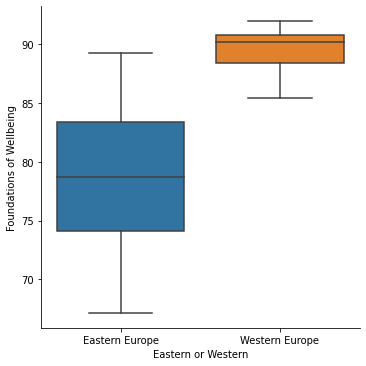

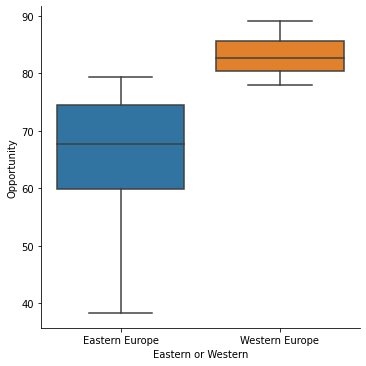

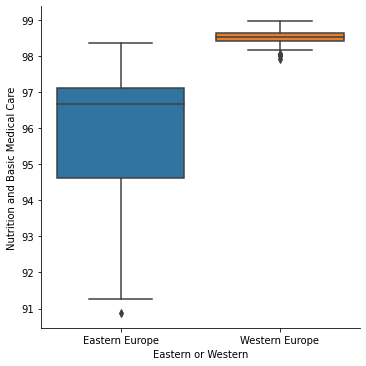

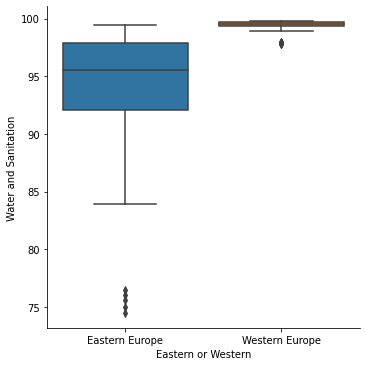

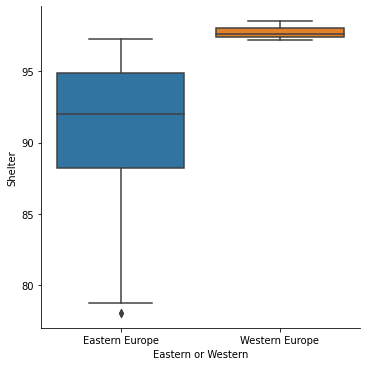

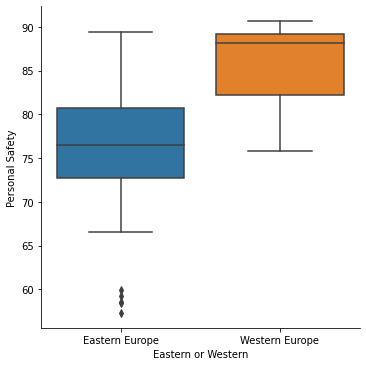

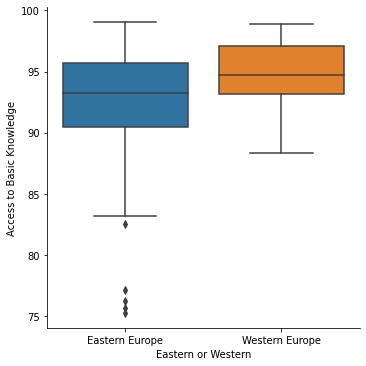

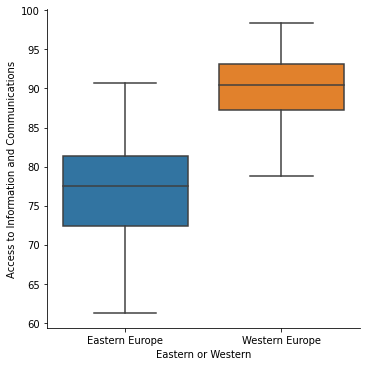

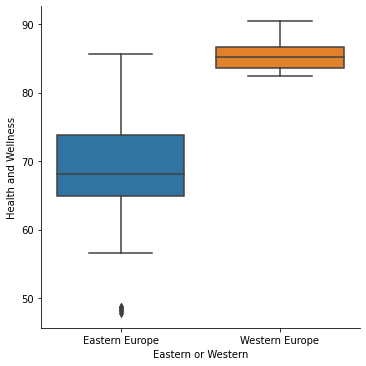

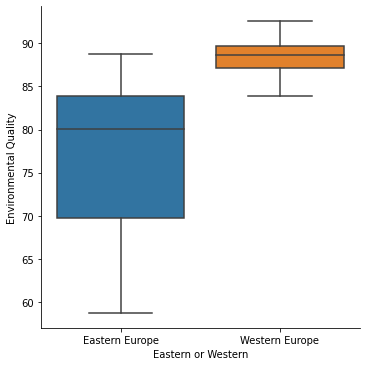

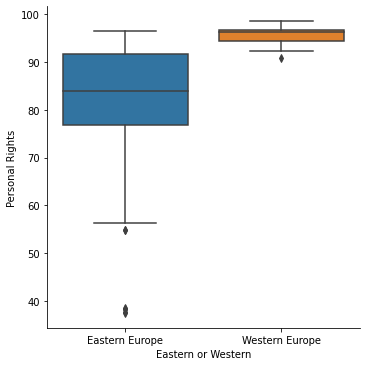

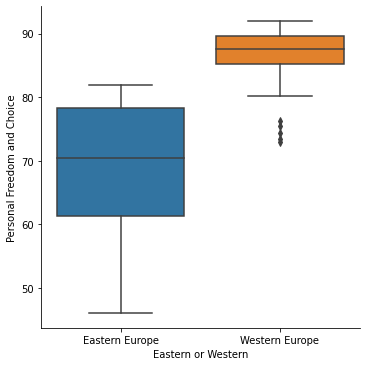

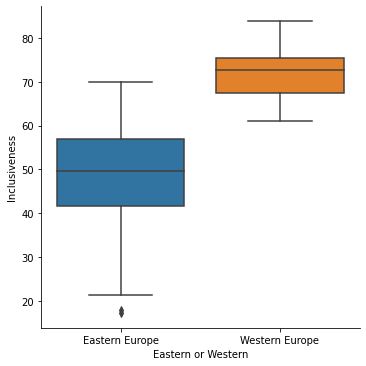

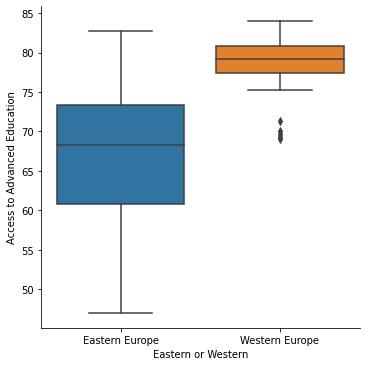

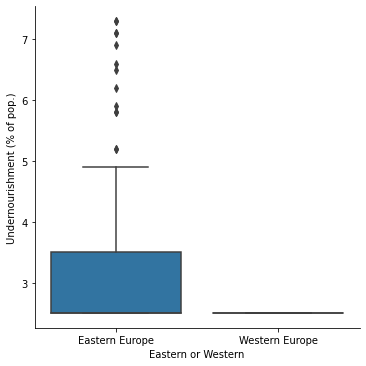

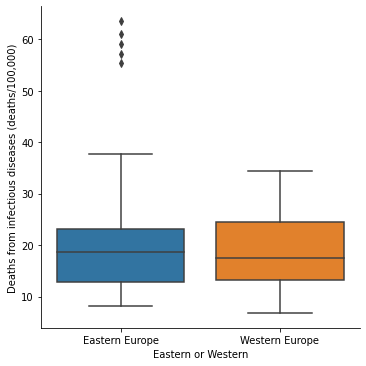

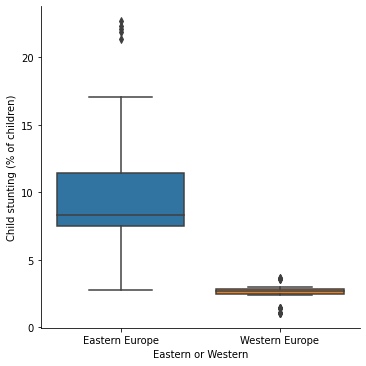

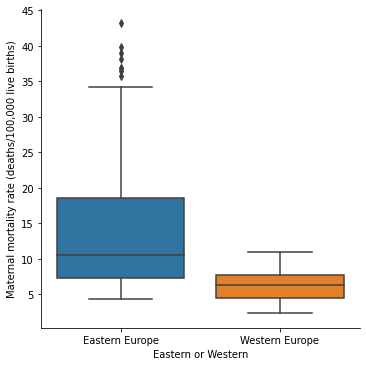

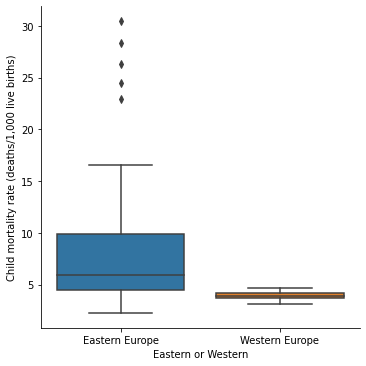

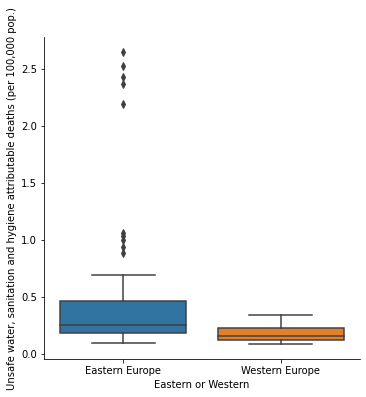

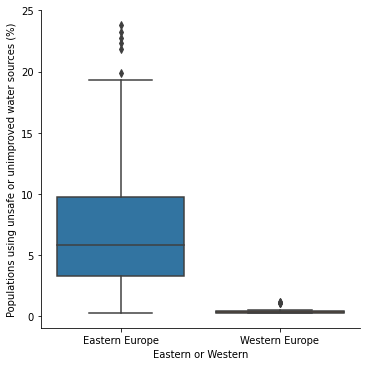

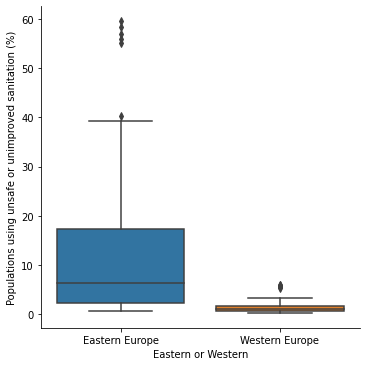

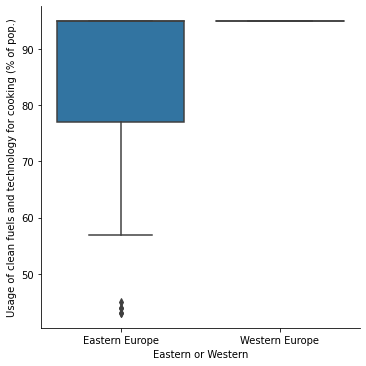

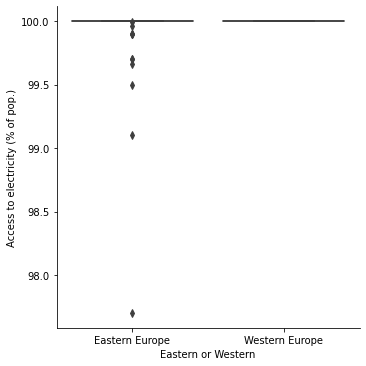

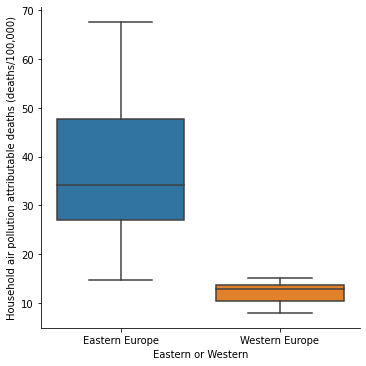

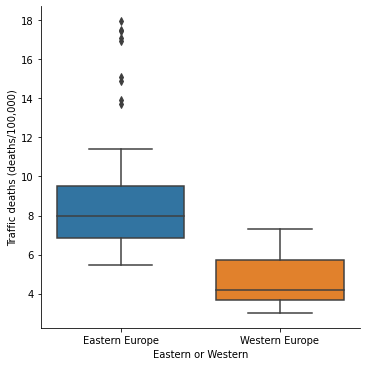

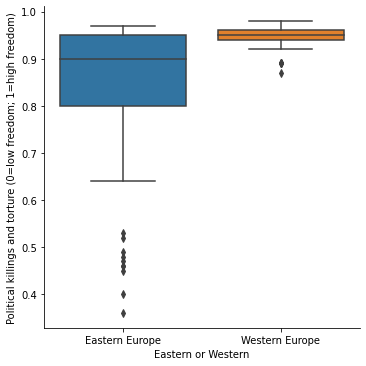

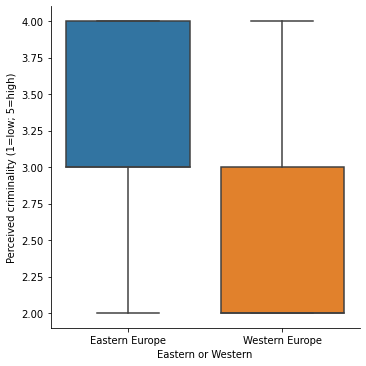

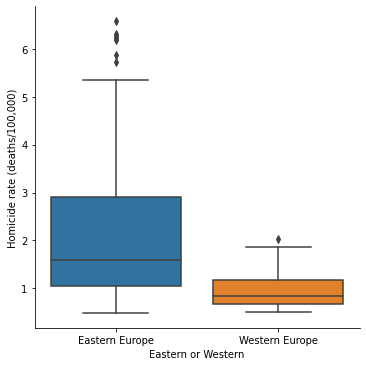

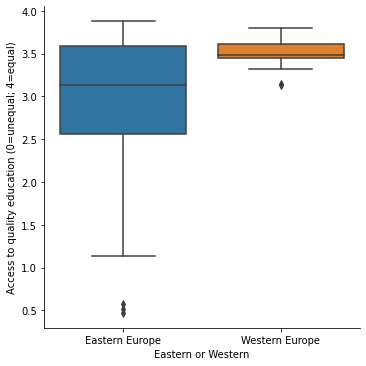

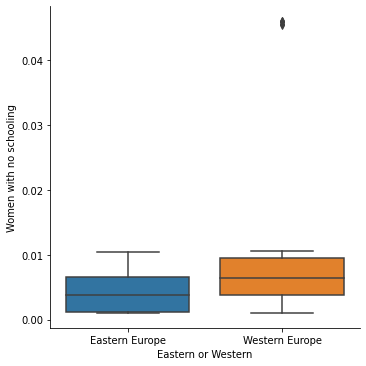

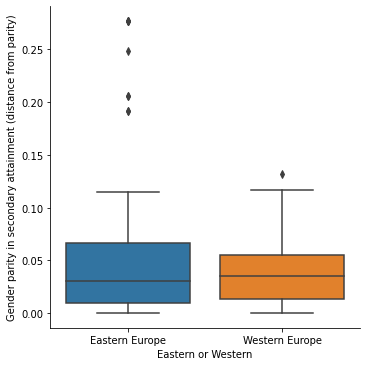

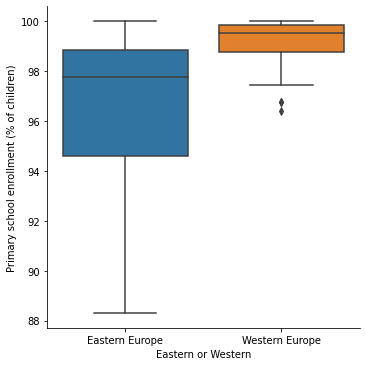

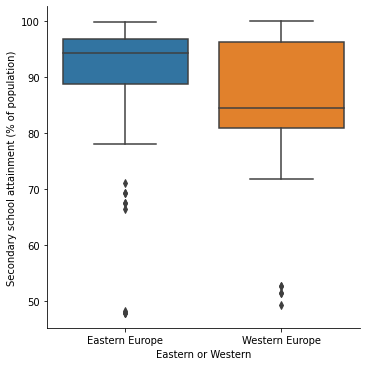

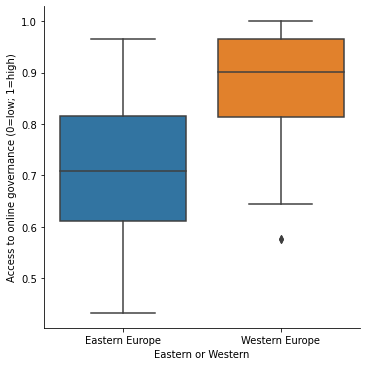

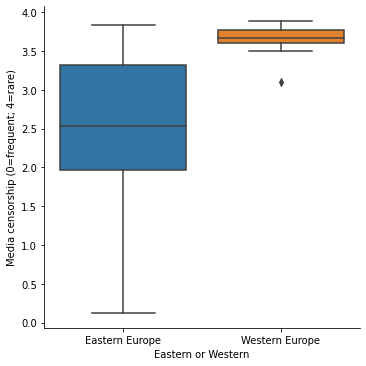

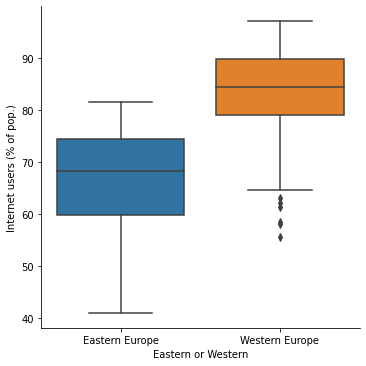

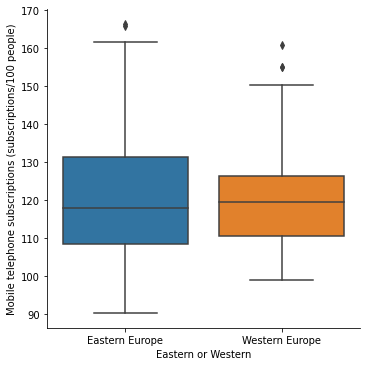

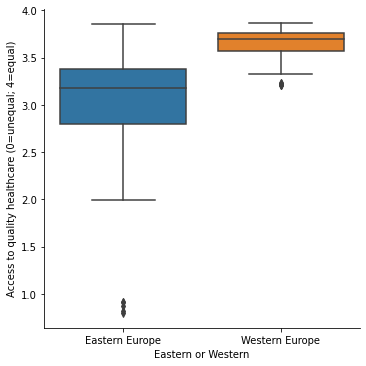

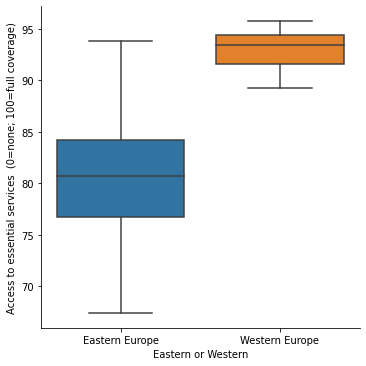

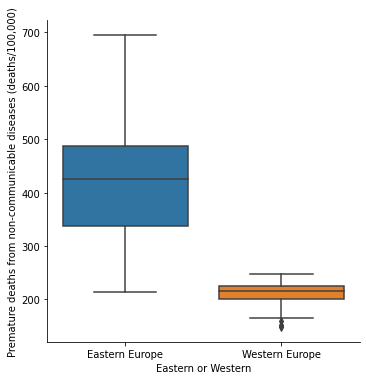

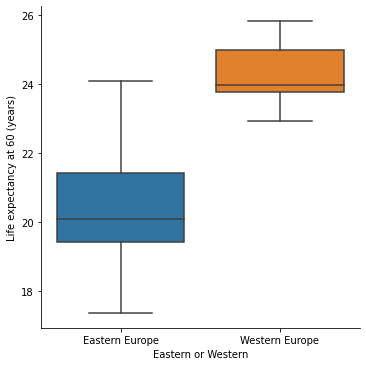

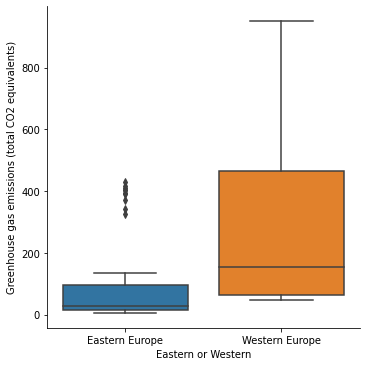

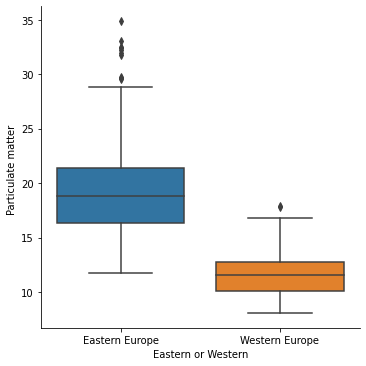

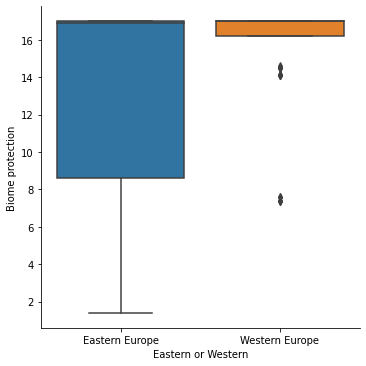

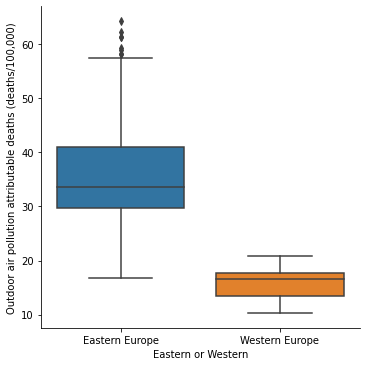

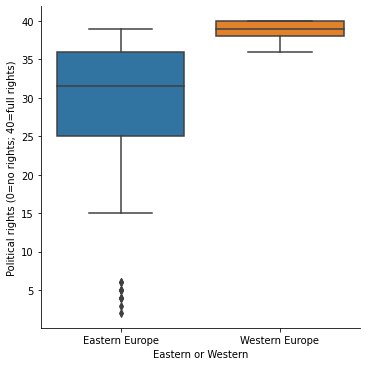

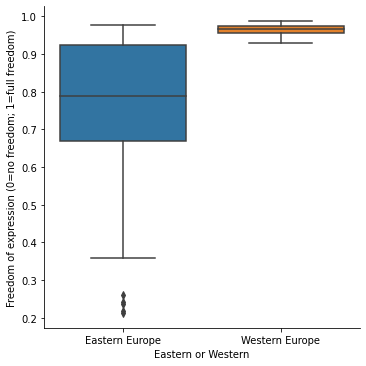

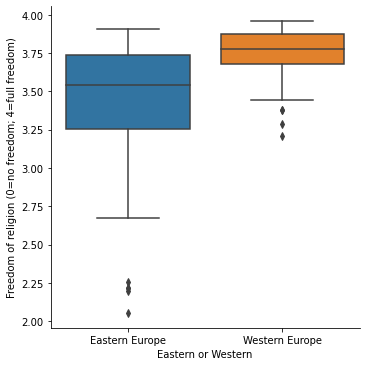

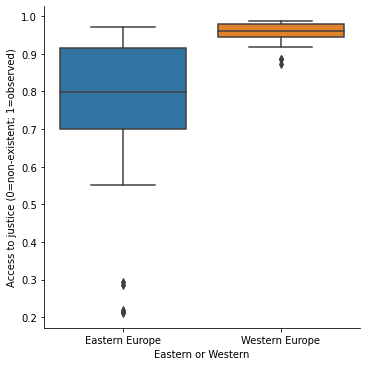

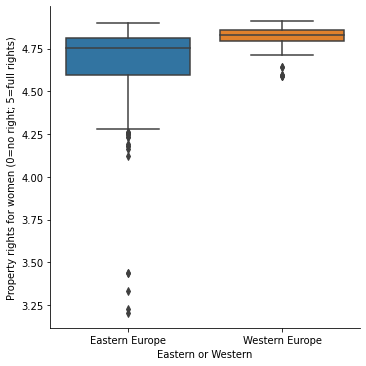

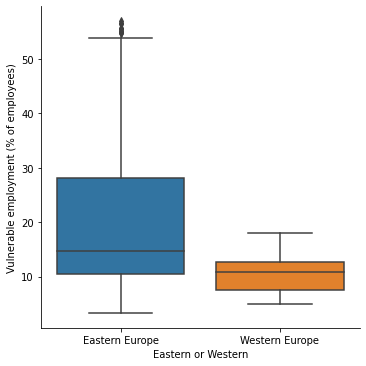

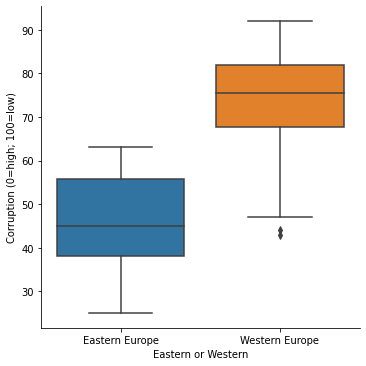

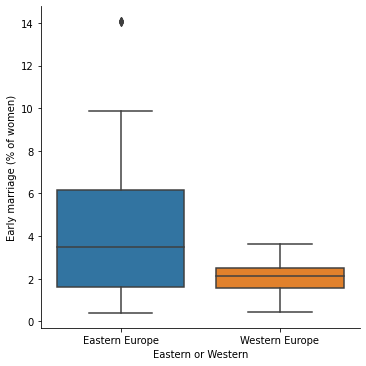

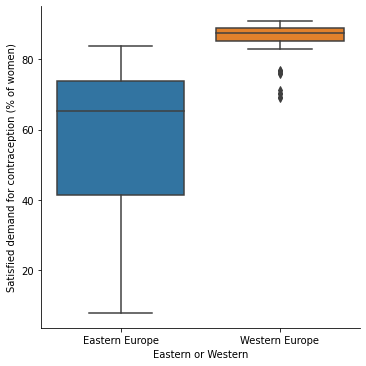

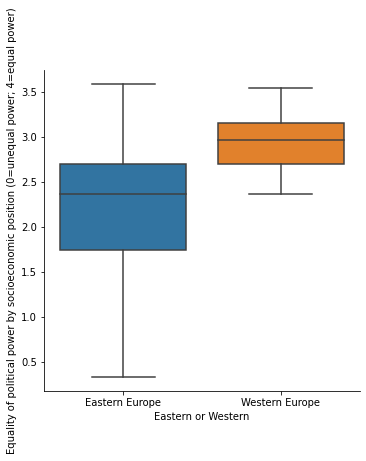

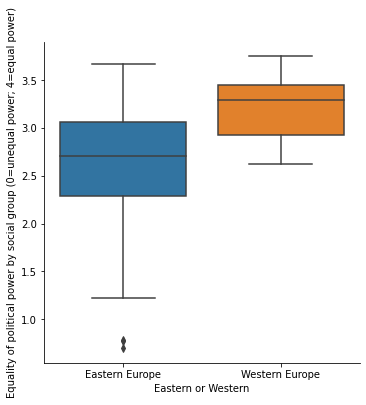

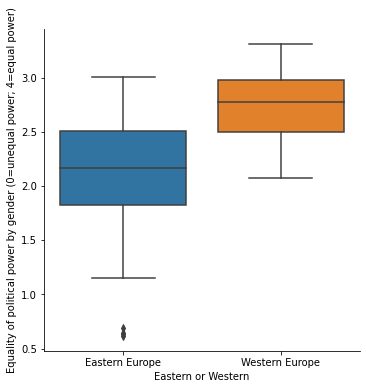

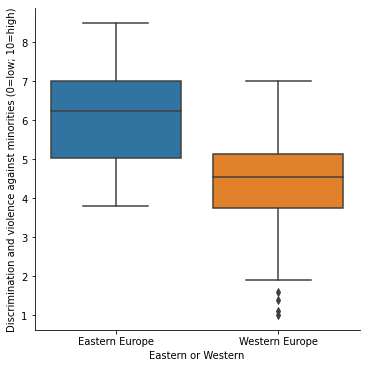

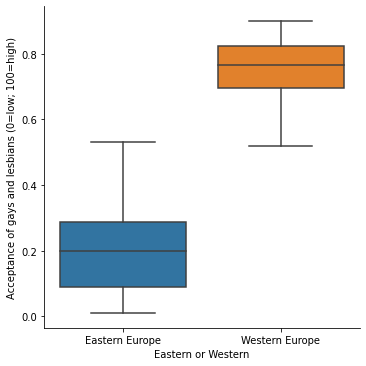

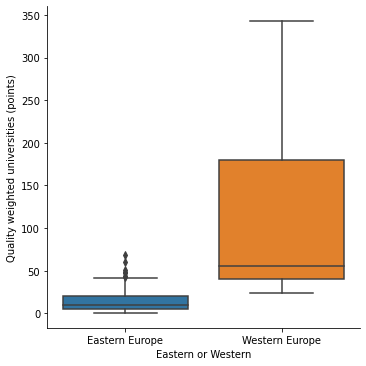

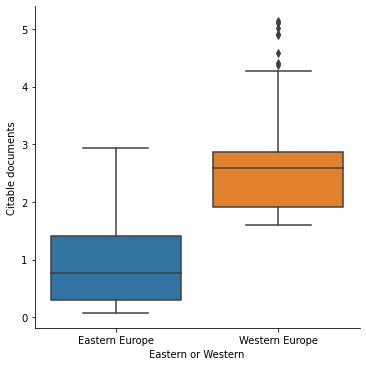

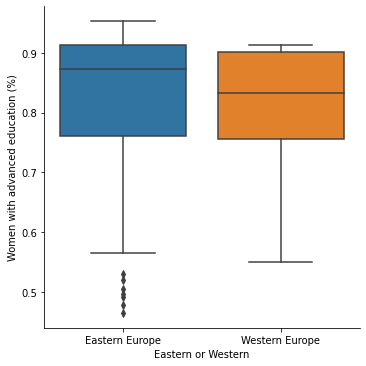

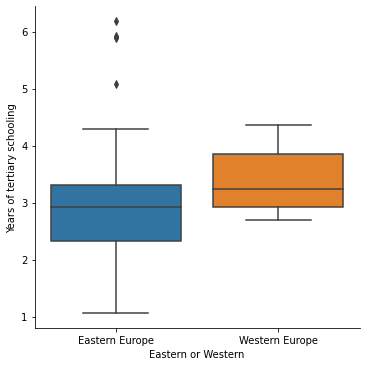

In [ ]:
for i in spi_metrics:
  sns.catplot(x="Eastern or Western", y=i, kind="box", data=df_europe)


We'd now like to find countries with similar happiness values to eastern European countries so we can compare their SPI metrics. 

In [ ]:
df_eastern = df_europe.loc[df_europe['Eastern or Western'] == 'Eastern Europe']
[df_eastern['Happiness Score'].min(), df_eastern['Happiness Score'].max()]

[4.09600019454956, 6.852]

In [ ]:
eastern_like = df_master.loc[(df_master['Happiness Score'] > 4.09600019454956) & (df_master['Happiness Score'] < 6.852)]

In [ ]:
for i, country in eastern_like['Country_y'].iteritems():
  if eastern.str.contains(country, regex = False).any():
    eastern_like.loc[i,'Eastern or Other'] = 'Eastern Europe'
  else:
    eastern_like.loc[i,'Eastern or Other'] = 'Other'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and ma

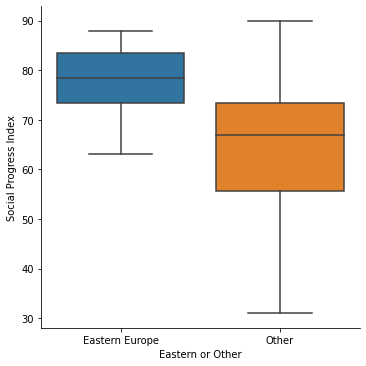

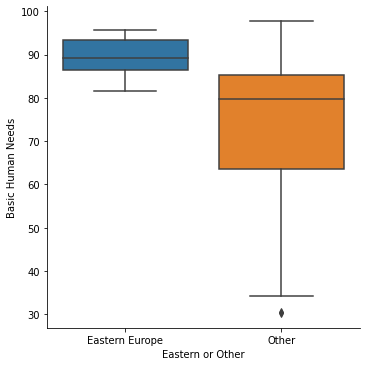

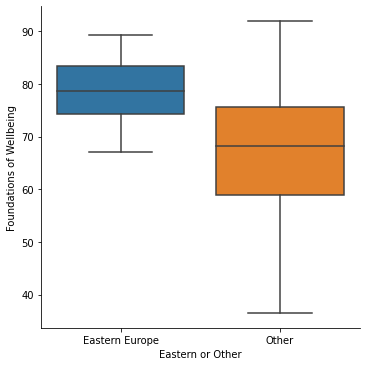

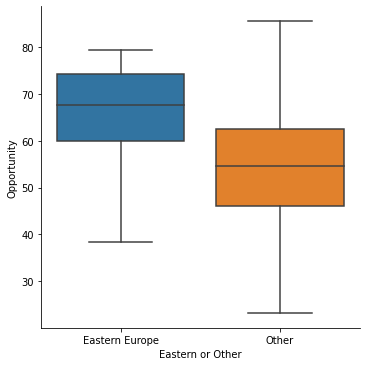

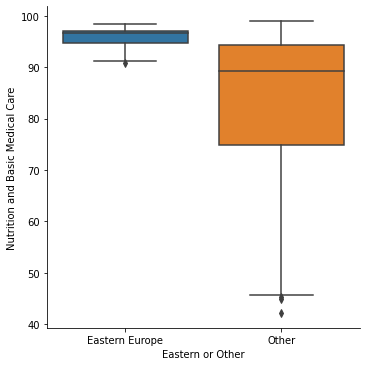

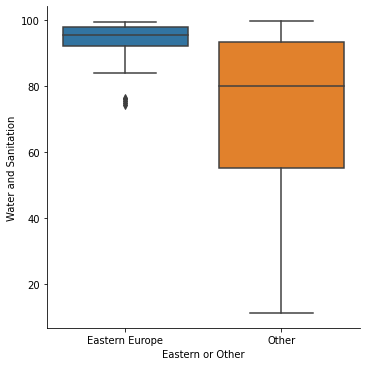

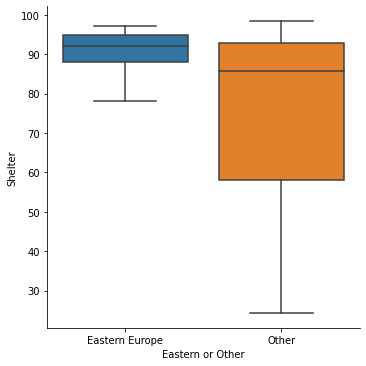

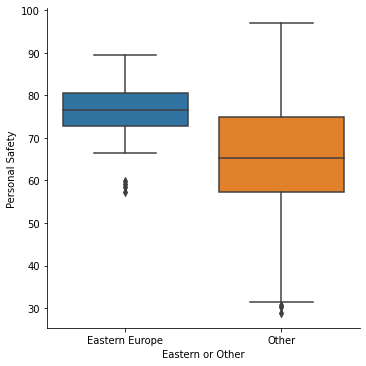

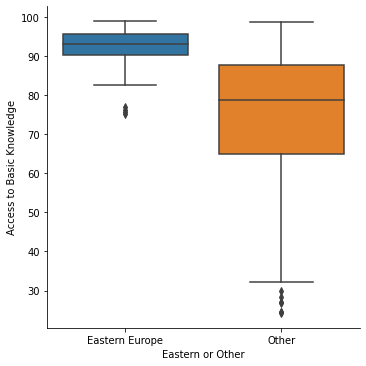

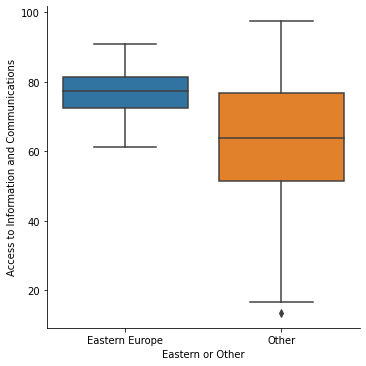

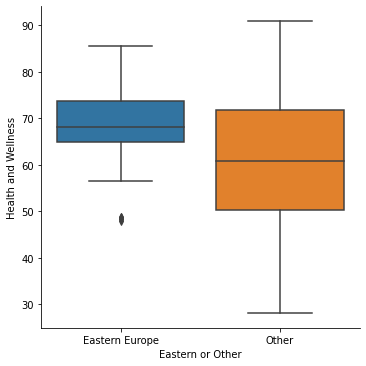

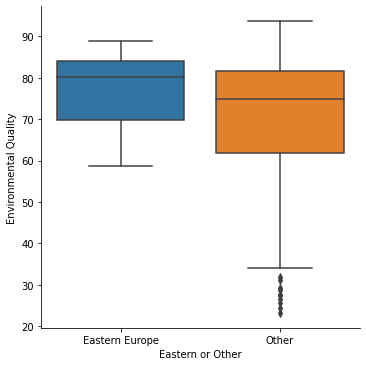

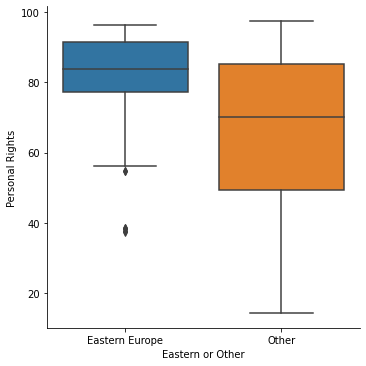

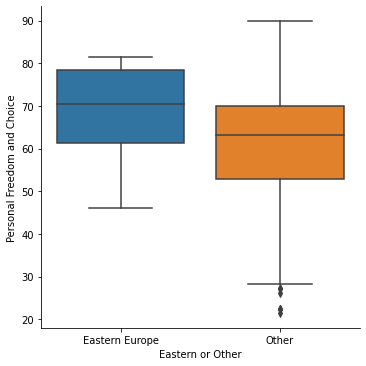

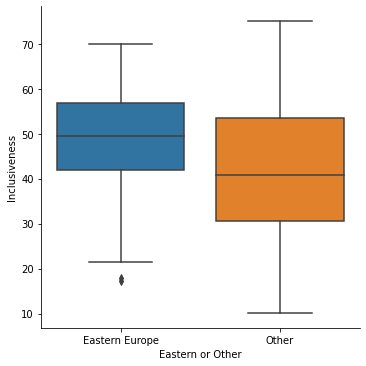

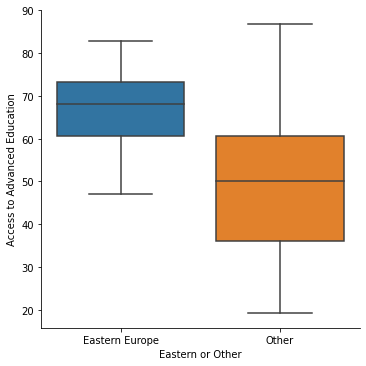

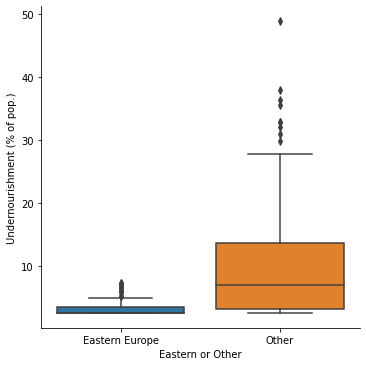

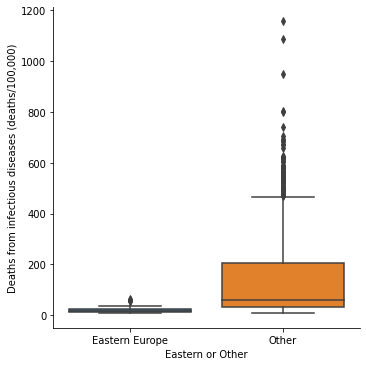

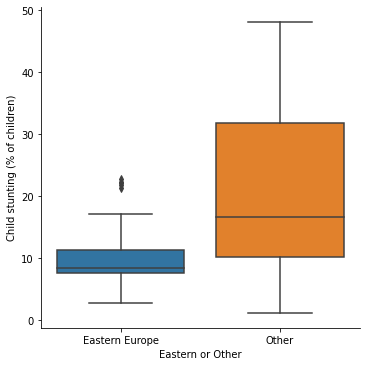

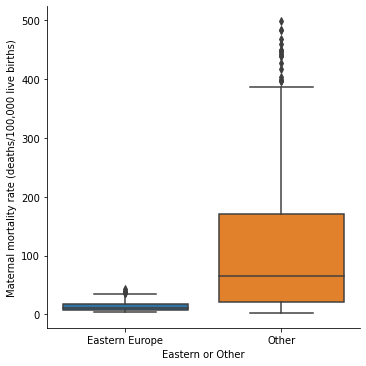

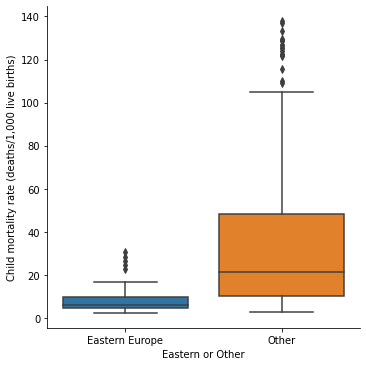

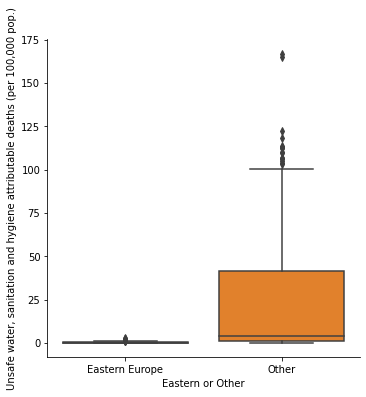

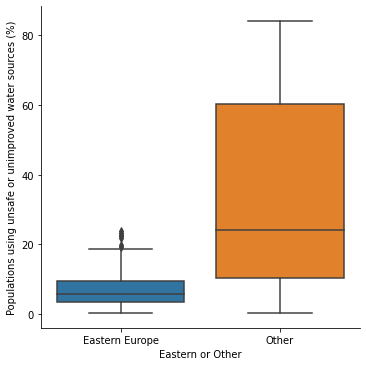

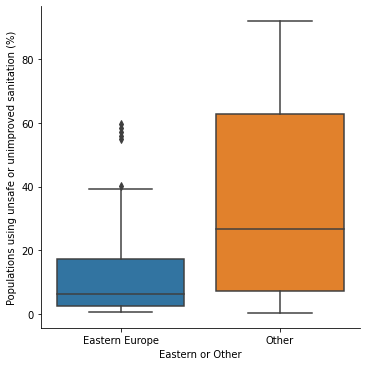

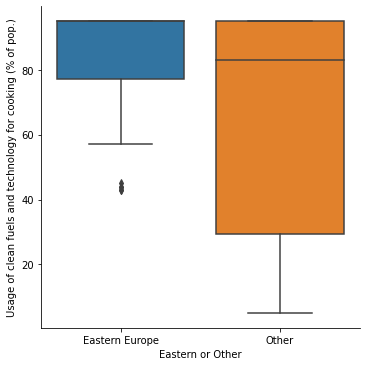

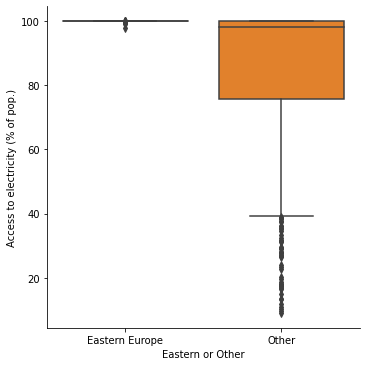

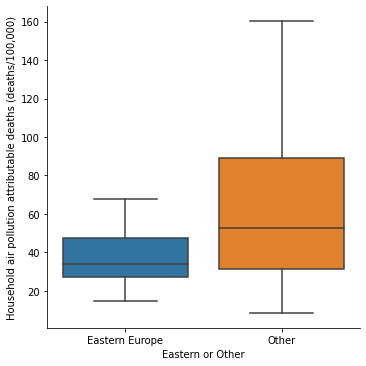

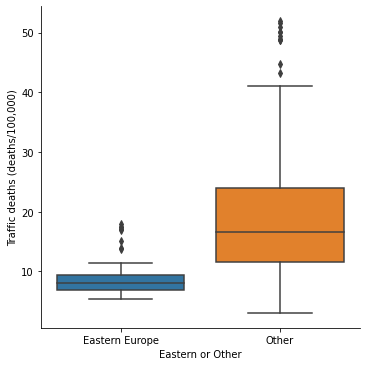

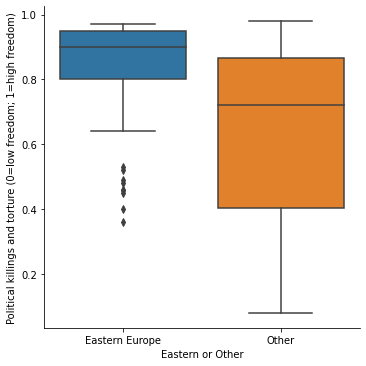

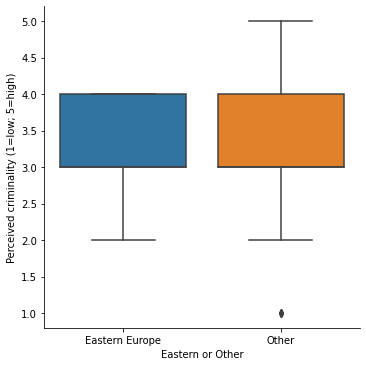

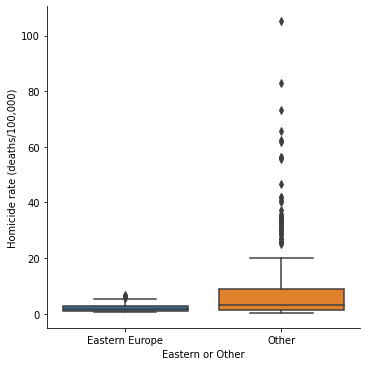

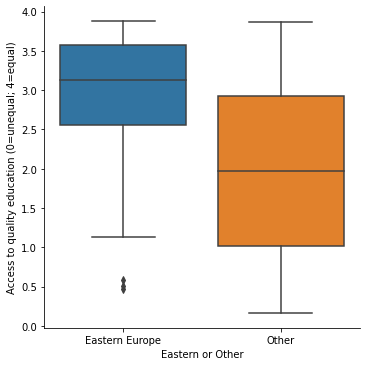

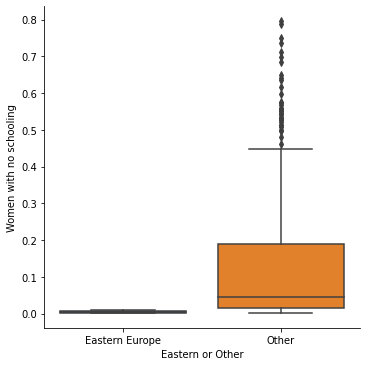

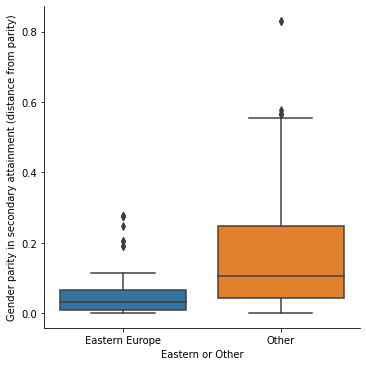

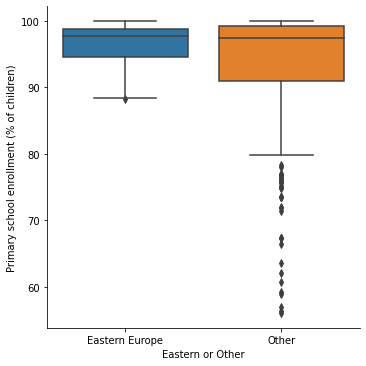

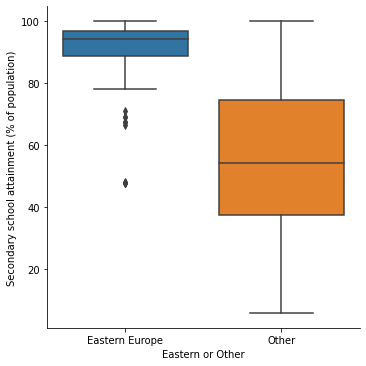

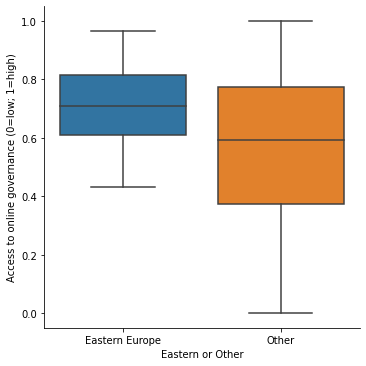

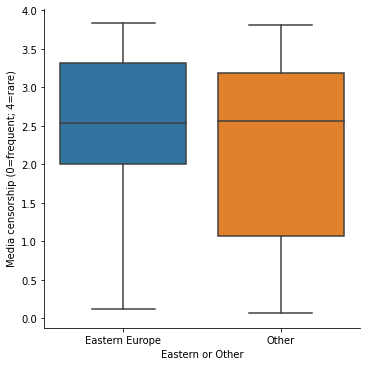

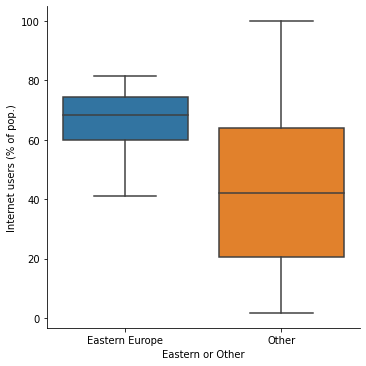

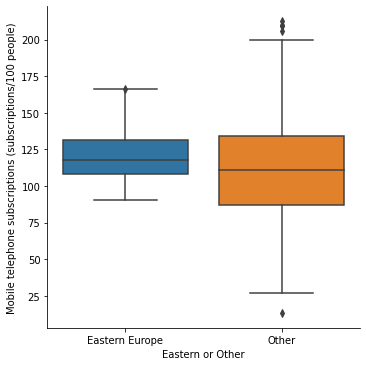

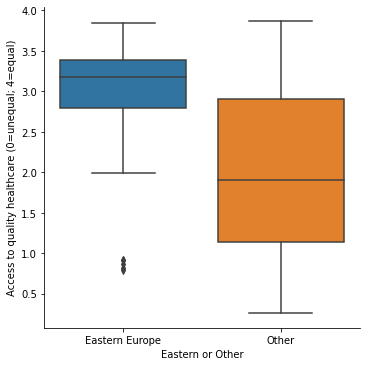

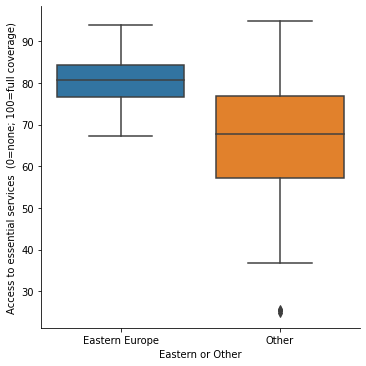

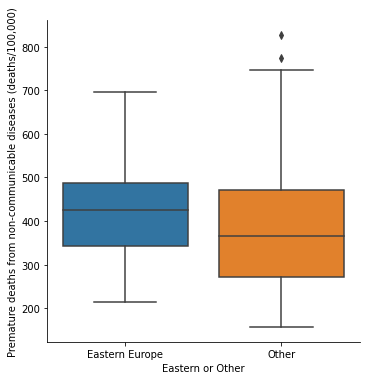

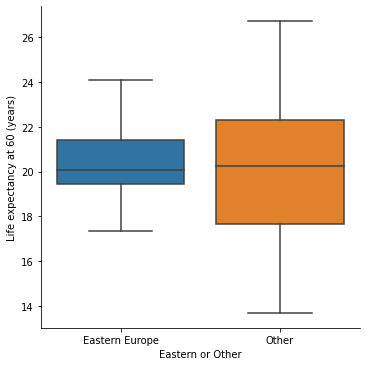

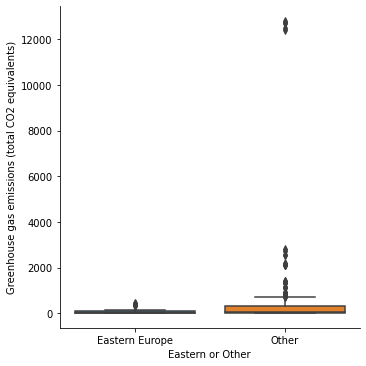

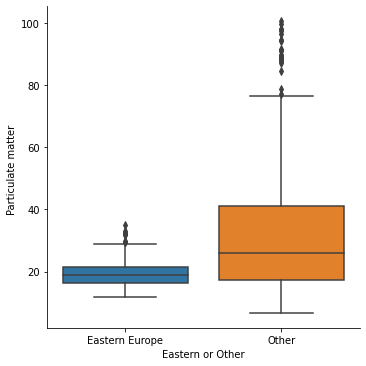

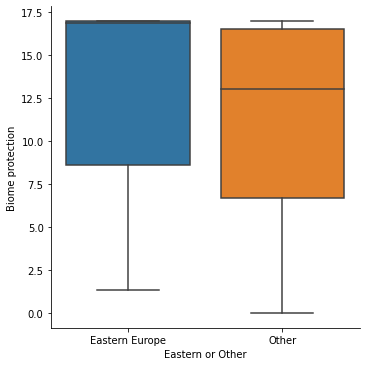

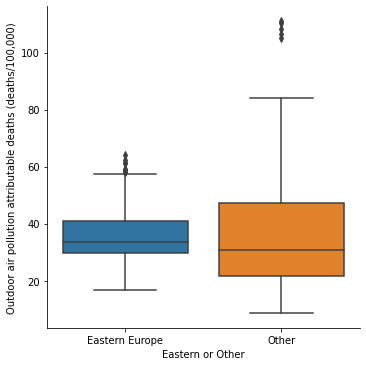

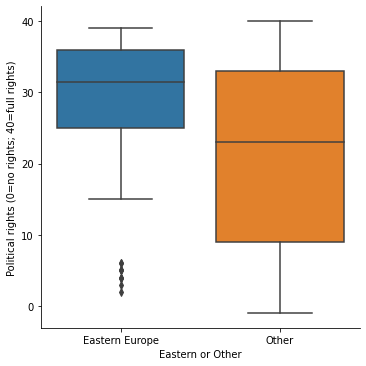

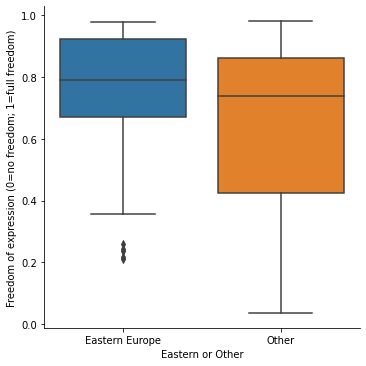

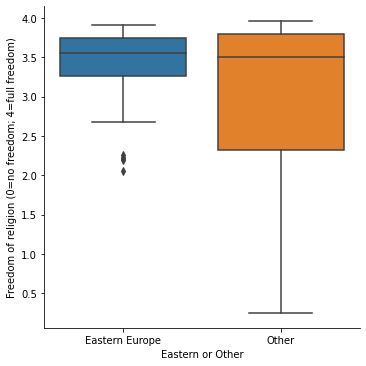

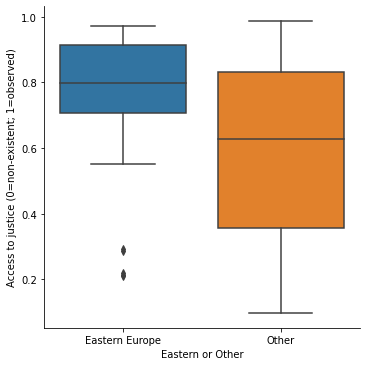

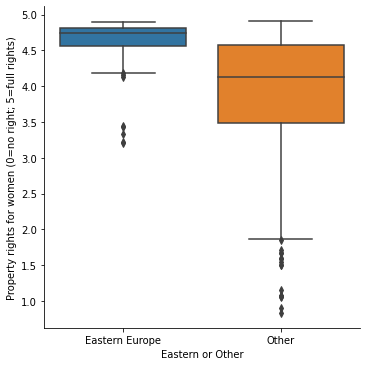

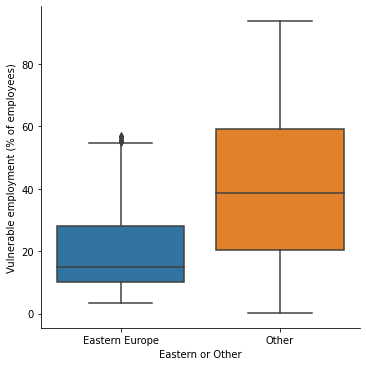

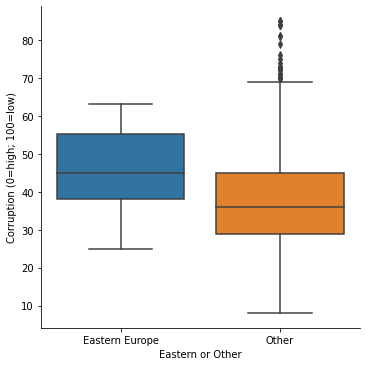

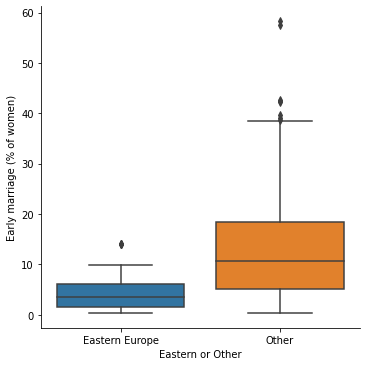

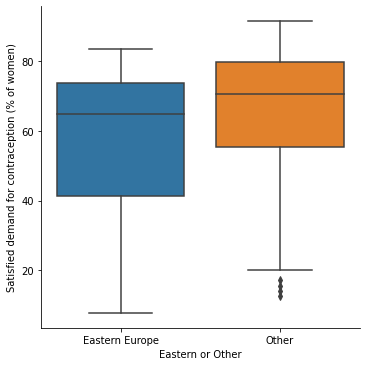

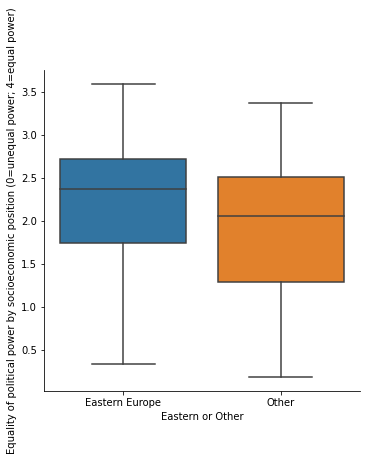

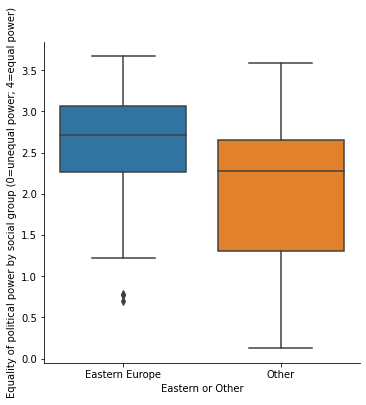

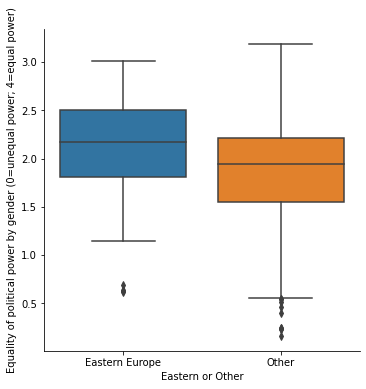

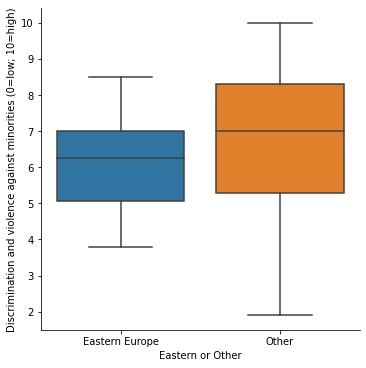

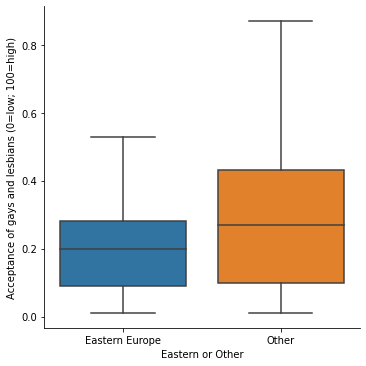

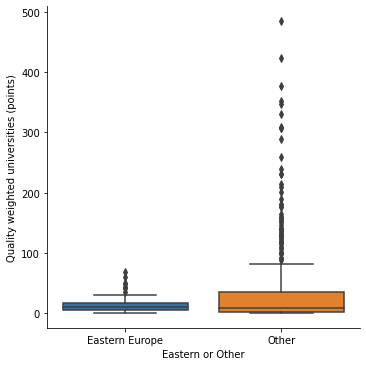

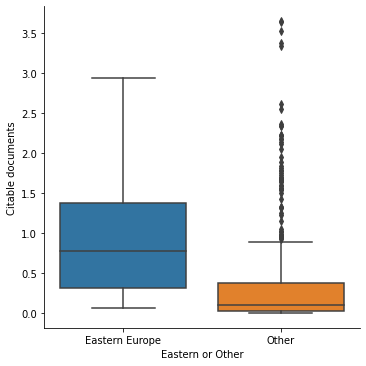

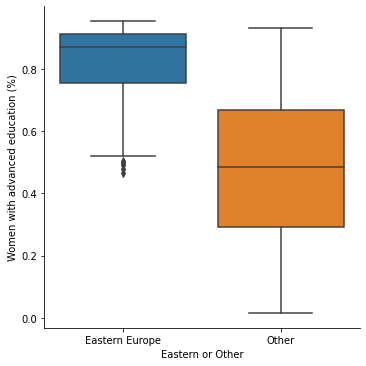

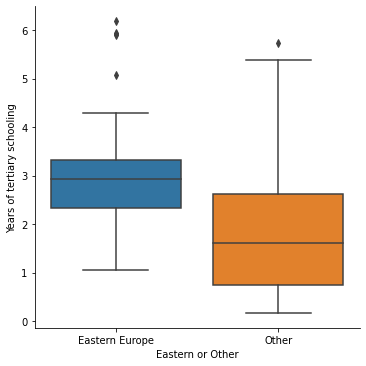

In [ ]:
for i in spi_metrics:
  sns.catplot(x="Eastern or Other", y=i, kind="box", data=eastern_like)


In [ ]:
from platform import python_version

print(python_version())

3.6.9


In [ ]:
eastern_like

,Unnamed: 0,SPI Rank,Country_x,SPI country code,SPI year,Status,Social Progress Index,Basic Human Needs,Foundations of Wellbeing,Opportunity,Nutrition and Basic Medical Care,Water and Sanitation,Shelter,Personal Safety,Access to Basic Knowledge,Access to Information and Communications,Health and Wellness,Environmental Quality,Personal Rights,Personal Freedom and Choice,Inclusiveness,Access to Advanced Education,Undernourishment (% of pop.),"Deaths from infectious diseases (deaths/100,000)",Child stunting (% of children),"Maternal mortality rate (deaths/100,000 live births)","Child mortality rate (deaths/1,000 live births)","Unsafe water, sanitation and hygiene attributable deaths (per 100,000 pop.)",Populations using unsafe or unimproved water sources (%),Populations using unsafe or unimproved sanitation (%),Usage of clean fuels and technology for cooking (% of pop.),Access to electricity (% of pop.),"Household air pollution attributable deaths (deaths/100,000)","Traffic deaths (deaths/100,000)",Political killings and torture (0=low freedom; 1=high freedom),Perceived criminality (1=low; 5=high),"Homicide rate (deaths/100,000)",Access to quality education (0=unequal; 4=equal),Women with no schooling,Gender parity in secondary attainment (distance from parity),...,Greenhouse gas emissions (total CO2 equivalents),Particulate matter,Biome protection,"Outdoor air pollution attributable deaths (deaths/100,000)",Political rights (0=no rights; 40=full rights),Freedom of expression (0=no freedom; 1=full freedom),Freedom of religion (0=no freedom; 4=full freedom),Access to justice (0=non-existent; 1=observed),Property rights for women (0=no right; 5=full rights),Vulnerable employment (% of employees),Corruption (0=high; 100=low),Early marriage (% of women),Satisfied demand for contraception (% of women),Equality of political power by socioeconomic position (0=unequal power; 4=equal power),Equality of political power by social group (0=unequal power; 4=equal power),Equality of political power by gender (0=unequal power; 4=equal power),Discrimination and violence against minorities (0=low; 10=high),Acceptance of gays and lesbians (0=low; 100=high),Quality weighted universities (points),Citable documents,Women with advanced education (%),Years of tertiary schooling,Index_country_year,Country_y,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Social support,Health (Life Expectancy),Freedom to make life choices,Trust (Government Corruption),Generosity,Dystopia Residual,Year,Continent,Year_DT,Adjusted Happiness Score,Combined Score,Eastern or Other
5,21,51.0,Albania,ALB,2019,Ranked,75.699997,86.690002,82.820000,57.580002,92.739998,90.320000,89.910004,73.779999,92.610001,79.470001,72.529999,86.680000,82.919998,46.980000,45.619999,54.799999,3.9,15.950600,21.325001,9.430,9.0222,0.289,17.911,13.098,78.0,100.0,32.236,7.829,0.940,4.0,2.0110,2.629,0.0077,0.0032,...,10.20,18.070000,17.0000,20.8107,28.0,0.736,3.846,0.872,4.252,53.785000,36.0,6.0719,7.9,1.283,2.454,2.323,4.3,0.10,4.4,0.1587,0.5195,2.8688,Albania 2019,Albania,NaN,107.0,4.719,0.947000,0.848000,0.874000,0.383000,0.027000,0.178000,NaN,2019.0,Europe,2019-01-01,47.190000,61.444998,Eastern Europe
6,22,51.0,Albania,ALB,2018,Ranked,75.320000,86.199997,81.540001,58.200001,92.379997,90.019997,89.519997,72.889999,90.930000,77.779999,72.349998,85.120003,83.970001,47.250000,47.410000,54.169998,4.5,16.146200,21.841000,9.302,9.2688,0.305,18.272,13.710,77.0,100.0,33.032,7.790,0.950,4.0,2.7369,2.191,0.0077,0.0054,...,9.88,18.201000,15.5118,21.7861,28.0,0.828,3.679,0.875,4.259,54.748001,38.0,6.1271,7.7,1.671,2.456,2.168,4.2,0.13,4.4,0.1291,0.5051,2.9191,Albania 2018,Albania,NaN,112.0,4.586,0.916000,0.817000,0.790000,0.419000,0.032000,0.149000,NaN,2018.0,Europe,2018-01-01,45.860000,60.590000,Eastern Europe
7,23,52.0,Albania,ALB,2017,Ranked,75.379997,86.190002,81.529999,58.430000,92.139999,89.639999,89.199997,73.769997,91.570000,77.000000,72.209999,85.339996,84.220001,47.470001,47.090000,54.9

In [ ]:
eastern_other = eastern_like.loc[eastern_like['Eastern or Other']=='Other']
eastern_other['Country_x'].unique()

array(['Algeria', 'Argentina', 'Bahrain', 'Bangladesh', 'Benin', 'Bhutan',
       'Bolivia', 'Botswana', 'Brazil', 'Burkina Faso', 'Cambodia',
       'Cameroon', 'Colombia', 'Congo, Democratic Republic of',
       'Congo, Republic of', "Côte d'Ivoire", 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
       'Eswatini', 'Ethiopia', 'France', 'Gabon', 'Gambia, The',
       'Germany', 'Ghana', 'Guatemala', 'Guinea', 'Haiti', 'Honduras',
       'Chad', 'Chile', 'China', 'India', 'Indonesia', 'Iran', 'Iraq',
       'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan',
       'Kenya', 'Korea, Republic of', 'Kuwait', 'Kyrgyzstan', 'Laos',
       'Lebanon', 'Lesotho', 'Liberia', 'Malawi', 'Malaysia', 'Mali',
       'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Mongolia',
       'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal',
       'Nicaragua', 'Niger', 'Nigeria', 'Pakistan', 'Panama', 'Paraguay',
       'Peru', 'Philippines', 'Portugal',

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


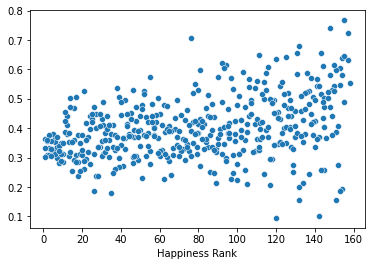

In [ ]:
sns.scatterplot(df_master['Happiness Rank'],df_master['Dystopia Residual'] / df_master['Happiness Score'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


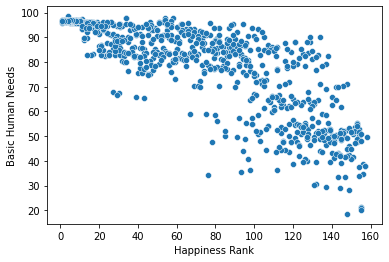

In [ ]:
sns.scatterplot(df_master['Happiness Rank'], df_master['Basic Human Needs'])

,SPI Rank,Country,SPI country code,SPI year,Status,Social Progress Index,Basic Human Needs,Foundations of Wellbeing,Opportunity,Nutrition and Basic Medical Care,Water and Sanitation,Shelter,Personal Safety,Access to Basic Knowledge,Access to Information and Communications,Health and Wellness,Environmental Quality,Personal Rights,Personal Freedom and Choice,Inclusiveness,Access to Advanced Education,Undernourishment (% of pop.),"Deaths from infectious diseases (deaths/100,000)",Child stunting (% of children),"Maternal mortality rate (deaths/100,000 live births)","Child mortality rate (deaths/1,000 live births)","Unsafe water, sanitation and hygiene attributable deaths (per 100,000 pop.)",Populations using unsafe or unimproved water sources (%),Populations using unsafe or unimproved sanitation (%),Usage of clean fuels and technology for cooking (% of pop.),Access to electricity (% of pop.),"Household air pollution attributable deaths (deaths/100,000)","Traffic deaths (deaths/100,000)",Political killings and torture (0=low freedom; 1=high freedom),Perceived criminality (1=low; 5=high),"Homicide rate (deaths/100,000)",Access to quality education (0=unequal; 4=equal),Women with no schooling,Gender parity in secondary attainment (distance from parity),Primary school enrollment (% of children),Secondary school attainment (% of population),Access to online governance (0=low; 1=high),Media censorship (0=frequent; 4=rare),Internet users (% of pop.),Mobile telephone subscriptions (subscriptions/100 people),Access to quality healthcare (0=unequal; 4=equal),Access to essential services (0=none; 100=full coverage),"Premature deaths from non-communicable diseases (deaths/100,000)",Life expectancy at 60 (years),Greenhouse gas emissions (total CO2 equivalents),Particulate matter,Biome protection,"Outdoor air pollution attributable deaths (deaths/100,000)",Political rights (0=no rights; 40=full rights),Freedom of expression (0=no freedom; 1=full freedom),Freedom of religion (0=no freedom; 4=full freedom),Access to justice (0=non-existent; 1=observed),Property rights for women (0=no right; 5=full rights),Vulnerable employment (% of employees),Corruption (0=high; 100=low),Early marriage (% of women),Satisfied demand for contraception (% of women),Equality of political power by socioeconomic position (0=unequal power; 4=equal power),Equality of political power by social group (0=unequal power; 4=equal power),Equality of political power by gender (0=unequal power; 4=equal power),Discrimination and violence against minorities (0=low; 10=high),Acceptance of gays and lesbians (0=low; 100=high),Quality weighted universities (points),Citable documents,Women with advanced education (%),Years of tertiary schooling,Index_country_year
0,NaN,World,WWW,2020,NaN,64.239998,74.650002,60.820000,57.250000,84.629997,74.720001,77.089996,62.150002,75.180000,70.330002,60.880001,36.869999,60.090000,63.240002,39.250000,66.419998,9.0970,134.023102,21.880400,99.3684,27.992300,29.6395,33.0701,28.3599,61.976398,89.4147,63.6366,16.406900,0.5517,3.6311,5.8298,1.6011,0.1113,0.1885,93.9408,61.9724,0.7555,1.7453,50.5871,104.4619,1.6325,69.2808,386.5131,20.1406,3458.2290,45.796902,8.1980,42.1951,19.872299,0.5126,2.3210,0.5821,3.8888,46.756901,40.756699,10.7239,73.859001,1.6918,1.6908,1.7663,7.3247,0.3343,223.065598,0.5025,0.5444,2.0406,World 2020
1,NaN,World,WWW,2019,NaN,64.320000,74.309998,60.750000,57.900002,84.360001,74.330002,76.480003,62.090000,74.930000,70.519997,60.650002,36.900002,61.560001,62.980000,41.259998,65.800003,9.0670,137.870499,22.249701,100.5704,28.952900,30.3240,33.1741,29.0734,61.192200,88.6713,64.7308,16.600500,0.5576,3.6313,5.9514,1.6096,0.1186,0.1893,93.8582,61.6925,0.7569,1.7978,49.2081,102.4113,1.6678,68.9432,392.6079,20.0348,3424.4524,45.704700,8.1850,42.1239,20.196800,0.5387,2.4278,0.5921,3.9068,46.832901,40.382999,10.8953,73.610298,1.8016,1.8458,1.9055,7.2709,0.3149,214.796295,0.4749,0.5308,2.0206,World 2019
2,NaN,World,WWW,2018,NaN,64.050003,74.05999

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


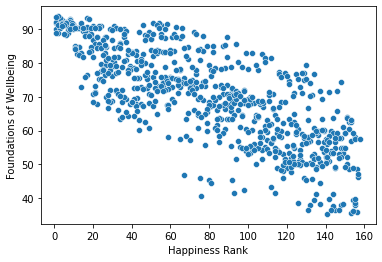

In [ ]:
sns.scatterplot(df_master['Happiness Rank'], df_master['Foundations of Wellbeing'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


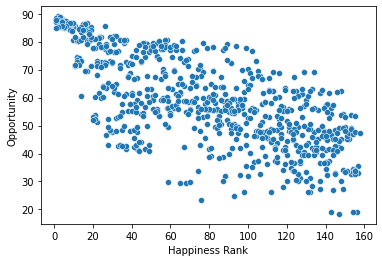

In [ ]:
sns.scatterplot(df_master['Happiness Rank'], df_master['Opportunity'])